# __Introduction__

We recieved review for our NAR submission on the ATAC-STARR method. For revisions we have a few analyses to do. 

1. We were asked to address orientation effects of promoters in our assay. Specifically, the review said the following: "Excluding larger effects of active promoters integrated into the 3' UTR conflicting with expression from the ORI seems premature without an in-depth analysis. I suggest that the authors analyze their RNA for promoter readouts based on direction of orientation in the 3' UTR to check these claims." So we will do exactly as suggested. I envision a correlation plot with RNA read counts comparing the 3'-5' vs. 5'-3' directions. 

2. We were also asked to investigate the differences in number of active regions called between ATAC-STARR and hiDRA. In my opinion, the likely answer is that this is driven by replicate number. However we should rule out several possibilities first. First, we should call HiDRA peaks using our bin method approach and compare to the peaks they call. This will tell us about any differences in data analysis. Second, we should identify what is called differently between the two and characterize those regions. My hypothesis is that HiDRA calls too many peaks as active. We could argue the correct number using eRNA data, the DNs identified in HiDRA, and other STARR-seq data. 

3. This was another comment: "Seeing more silencing than activating elements, while repressing elements seem to contribute less in previous STARR-seq and other MPRA studies." This may be revelaed in the first step, since most silencers are promoters, so hold off on this for now. I do think we could rationalize why we see more, I just don't know the correct 1st step without knowing the answer to part 1. 

Below I detail these analyses. I will start with bullet point #1. 

# __Orientation Effects of Promoters__

The question here is do promoters in the 3'UTR affect reporter RNA stability and expression due to transcription conflicts. If this were true, orientation of the promoters would alter Reporter RNA levels in one oreintation but not the other. To address this, I will bisect my mapped reads files into two based on the orientation. This is a little tricky, but can be accomplished using sam flags (see below). After parsing, I will then make a counts matrix for all promoter annotated bins, normalize by cpm and calcualte correlation coefficients. Correlations close to 1 will indicate that orientation doesn't alter the RNA levels. Other correlations will indicate there is some effect and this could be seen on a correlation plot. 

## _Step 1: merge replicate bam files (if not already done) and seperate reads into 5'-3' or 3'-5' files._ 

This is pretty tricky to think about but is easy in execution. See the diagram below too understand why I used the particular sam flags that I did. 

![](Orientation_diagram.png)

The important thing to note is that the read 1 position is fixed on the plasmid and on the reporter RNAs, so the first read in a mate pair will always be from the 5' end of the plasmid. In this way if read 1 maps to the reverse strand, then the insert is in a 3' to 5' orientation.

I will do two samtools view commands with the -f flag (only include reads with this flag) to get the R1 and R2 for either orientation and then merge and name sort the R1 and R2 together for each orientation. 

In [3]:
%%bash
# I already generated a merged file. Use this file in the bisection. 
# If this works, the total read count should equal that of the merged file. 

module restore tools

BAM_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/merged_replicates'
RESULTS_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'

#5'-3' orientation
#Read 1 - sam flag = 99
samtools view -@ 2 -f 99 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${RESULTS_DIR}/5-to-3_R1_GG-RNA.bam

#Read 2 - sam flag = 147
samtools view -@ 2 -f 147 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${RESULTS_DIR}/5-to-3_R2_GG-RNA.bam
    
#Merge reads together. This syntax is dumb, so be careful: samtools merge <out.bam> <in1.bam> [<in2.bam> ... <inN.bam>]
samtools merge -@ 2 -O bam ${RESULTS_DIR}/5-to-3_R1+R2_GG-RNA.bam \
    ${RESULTS_DIR}/5-to-3_R1_GG-RNA.bam ${RESULTS_DIR}/5-to-3_R2_GG-RNA.bam
    
#3'-5' orientation
#Read 1 - sam flag = 83
samtools view -@ 2 -f 83 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${RESULTS_DIR}/3-to-5_R1_GG-RNA.bam

#Read 2 - sam flag = 163
samtools view -@ 2 -f 163 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${RESULTS_DIR}/3-to-5_R2_GG-RNA.bam
    
#Merge reads together. This syntax is dumb, so be careful: samtools merge <out.bam> <in1.bam> [<in2.bam> ... <inN.bam>]
samtools merge -@ 2 -O bam ${RESULTS_DIR}/3-to-5_R1+R2_GG-RNA.bam \
    ${RESULTS_DIR}/3-to-5_R1_GG-RNA.bam ${RESULTS_DIR}/3-to-5_R2_GG-RNA.bam

Restoring modules from user's tools
[bam_merge] File '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis/5-to-3_R1+R2_GG-RNA.bam' exists. Please apply '-f' to overwrite. Abort.
[bam_merge] File '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis/3-to-5_R1+R2_GG-RNA.bam' exists. Please apply '-f' to overwrite. Abort.


CalledProcessError: Command 'b"# I already generated a merged file. Use this file in the bisection. \n# If this works, the total read count should equal that of the merged file. \n\nmodule restore tools\n\nBAM_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/merged_replicates'\nRESULTS_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'\n\n#5'-3' orientation\n#Read 1 - sam flag = 99\nsamtools view -@ 2 -f 99 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \\\n    ${RESULTS_DIR}/5-to-3_R1_GG-RNA.bam\n\n#Read 2 - sam flag = 147\nsamtools view -@ 2 -f 147 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \\\n    ${RESULTS_DIR}/5-to-3_R2_GG-RNA.bam\n    \n#Merge reads together. This syntax is dumb, so be careful: samtools merge <out.bam> <in1.bam> [<in2.bam> ... <inN.bam>]\nsamtools merge -@ 2 -O bam ${RESULTS_DIR}/5-to-3_R1+R2_GG-RNA.bam \\\n    ${RESULTS_DIR}/5-to-3_R1_GG-RNA.bam ${RESULTS_DIR}/5-to-3_R2_GG-RNA.bam\n    \n#3'-5' orientation\n#Read 1 - sam flag = 83\nsamtools view -@ 2 -f 83 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \\\n    ${RESULTS_DIR}/3-to-5_R1_GG-RNA.bam\n\n#Read 2 - sam flag = 163\nsamtools view -@ 2 -f 163 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \\\n    ${RESULTS_DIR}/3-to-5_R2_GG-RNA.bam\n    \n#Merge reads together. This syntax is dumb, so be careful: samtools merge <out.bam> <in1.bam> [<in2.bam> ... <inN.bam>]\nsamtools merge -@ 2 -O bam ${RESULTS_DIR}/3-to-5_R1+R2_GG-RNA.bam \\\n    ${RESULTS_DIR}/3-to-5_R1_GG-RNA.bam ${RESULTS_DIR}/3-to-5_R2_GG-RNA.bam\n"' returned non-zero exit status 1.

In [6]:
%%bash

BAM_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/merged_replicates'
RESULTS_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'

#Merge reads together. This syntax is dumb, so be careful: samtools merge <out.bam> <in1.bam> [<in2.bam> ... <inN.bam>]
samtools merge -f -@ 2 -O bam ${RESULTS_DIR}/5-to-3_R1+R2_GG-RNA.bam \
    ${RESULTS_DIR}/5-to-3_R1_GG-RNA.bam ${RESULTS_DIR}/5-to-3_R2_GG-RNA.bam

#Merge reads together. This syntax is dumb, so be careful: samtools merge <out.bam> <in1.bam> [<in2.bam> ... <inN.bam>]
samtools merge -f -@ 2 -O bam ${RESULTS_DIR}/3-to-5_R1+R2_GG-RNA.bam \
    ${RESULTS_DIR}/3-to-5_R1_GG-RNA.bam ${RESULTS_DIR}/3-to-5_R2_GG-RNA.bam

## _Step 2: Parse bins by proximal and distal using TSS annotation provided by ChIPSeeker._ 
I will count reads in proximal bins and distal bins, with the hypothesis that proximal bins might be more affected by orientation. To do this, annotate the bins with chipseeker and filter by annotation. 

In [5]:
%%bash 

DIR="/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink"

#first convert bins.saf to bed file. 
awk 'BEGIN{OFS=FS="\t"}{if (NR>1) print $2,$3,$4,$1,$5,"."}' ${DIR}/bins.saf > ${DIR}/bins.bed

In [1]:
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

input <- '/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink'

bins_anno <- annotatePeak(paste0(input,"/bins.bed"), 
                          tssRegion = c(-2000, 1000), 
                          TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene)



ChIPseeker v1.28.3  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383

Loading required package: GenomicFeatures

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grep

>> loading peak file...				 2021-11-09 09:52:34 AM 
>> preparing features information...		 2021-11-09 09:53:59 AM 
>> identifying nearest features...		 2021-11-09 09:54:02 AM 
>> calculating distance from peak to TSS...	 2021-11-09 09:56:41 AM 
>> assigning genomic annotation...		 2021-11-09 09:56:41 AM 
>> assigning chromosome lengths			 2021-11-09 09:58:40 AM 
>> done...					 2021-11-09 09:58:40 AM 


In [2]:
#convert anno to df and head. Note that the start is in 1-based format. I'll have to change this. 
bins_anno_df <- as.data.frame(bins_anno)
head(bins_anno_df)

,seqnames,start,end,width,strand,V4,V5,V6,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>
1,chr1,267897,267945,49,*,bin_1,.,.,"Exon (ENST00000424587.7/ENST00000424587.7, exon 4 of 4)",1,187891,187958,68,2,102466751,ENST00000612080.1,-79939
2,chr1,267907,267955,49,*,bin_2,.,.,"Exon (ENST00000424587.7/ENST00000424587.7, exon 4 of 4)",1,187891,187958,68,2,102466751,ENST00000612080.1,-79949
3,chr1,267917,267965,49,*,bin_3,.,.,"Exon (ENST00000424587.7/ENST00000424587.7, exon 4 of 4)",1,187891,187958,68,2,102466751,ENST00000612080.1,-79959
4,chr1,267927,267975,49,*,bin_4,.,.,"Exon (ENST00000424587.7/ENST00000424587.7, exon 4 of 4)",1,187891,187958,68,2,102466751,ENST00000612080.1,-79969
5,chr1,267937,267985,49,*,bin_5,.,.,"Exon (ENST00000424587.7/ENST00000424587.7, exon 4 of 4)",1,187891,187958,68,2,102466751,ENST00000612080.1,-79979
6,chr1,267947,267995,49,*,bin_6,.,.,"Exon (ENST00000424587.7/ENST00000424587.7, exon 4 of 4)",1,187891,187958,68,2,102466751,ENST00000612080.1,-79989


In [3]:
#Filter based on promoter annotation.
prom_bins <- dplyr::filter(bins_anno_df, stringr::str_detect(annotation, 'Promoter'))
enhc_bins <- dplyr::filter(bins_anno_df, !stringr::str_detect(annotation, 'Promoter'))

#check that this worked. Total number of rows should equal the sum of the two. This returns TRUE if correct. 
all(nrow(bins_anno_df) == (nrow(enhc_bins) + nrow(prom_bins)))

#print nrow for each to have an idea of counts. 
nrow(prom_bins)
nrow(enhc_bins)

[1] TRUE

[1] 2382142

[1] 3827480

In [7]:
library(tidyverse)
#select the first 3 columns for each to format to bed file format. 
#Before that correct the Start position which gets +1 shifted from ChIPSeeker for some dumb reason. 
prom_bins_bed <- mutate(prom_bins, bed_start = start - 1) %>% dplyr::select(seqnames, bed_start, end)
enhc_bins_bed <- mutate(enhc_bins, bed_start = start - 1) %>% dplyr::select(seqnames, bed_start, end)

#write to new bed file in results directory. 
results <- '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'
readr::write_tsv(x = prom_bins_bed, paste0(results, "/GG_promoter_bins.bed"), col_names = FALSE)
readr::write_tsv(x = enhc_bins_bed, paste0(results, "/GG_enhancer_bins.bed"), col_names = FALSE)

## _Step 3: Convert 3-column bed files to SAF for use in step 4 below._
We need to have bins in simple annoation format for use in featureCounts. Convert using a simple awk function. 

In [1]:
%%bash
DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'
for i in promoter enhancer
do
    awk '{OFS=FS="\t"}; BEGIN{print "GeneID","Chr","Start","End","Strand"};{print "name_"NR,$1,$2,$3,"."}' \
    ${DIR}/GG_${i}_bins.bed > ${DIR}/GG_${i}_bins.saf
done

#Show saf format with head. 
head ${DIR}/GG_promoter_bins.saf

GeneID Chr Start End Strand
name_1	chr1	778321	778370	.
name_2	chr1	778331	778380	.
name_3	chr1	778341	778390	.
name_4	chr1	778351	778400	.
name_5	chr1	778361	778410	.
name_6	chr1	778371	778420	.
name_7	chr1	778381	778430	.
name_8	chr1	778391	778440	.
name_9	chr1	778401	778450	.


## _Step 4: Assemble Counts Matrix._
Use feature counts to make three counts matricies, one for each of the two saf files. 

In [7]:
%%bash 
DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'

for i in promoter enhancer
do
    featureCounts -p -O -B --minOverlap 1 -T 3 -F SAF \
    -a ${DIR}/GG_${i}_bins.saf \
    -o ${DIR}/GG_${i}_orientation-speciefic-counts.tsv \
    ${DIR}/5-to-3_R1+R2_GG-RNA.bam \
    ${DIR}/3-to-5_R1+R2_GG-RNA.bam 
done


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 2 BAM files                                      ||
||                           o 5-to-3_R1+R2_GG-RNA.bam                        ||
||                           o 3-to-5_R1+R2_GG-RNA.bam                        ||
||                                                                            ||
||             Output file : GG_promoter_orientation-speciefic-co

## _Step 5: In R, calculate cpm-nromalized read count correlation and display as scatter plot._
Use this formula to convert raw counts to counts per million for each bin: cpm = count / (total counts/1 million). 

In [10]:
library(tidyverse)

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis/'

#read tsvs into R. Yes I realize I spelled specific wrong..  
prom_cts <- read_tsv(paste0(dir, "/GG_promoter_orientation-speciefic-counts.tsv"),
                     col_names = c("Name_ID", "Chr", "Start", "End", "Strand", "Length", "5_3", "3_5"), 
                     col_types = "cciiciii", skip = 2) %>% mutate(Start = Start-1)

enhc_cts <- read_tsv(paste0(dir, "/GG_enhancer_orientation-speciefic-counts.tsv"),
                     col_names = c("Name_ID", "Chr", "Start", "End", "Strand", "Length", "5_3", "3_5"), 
                     col_types = "cciiciii", skip = 2) %>% mutate(Start = Start-1)

#calculate "per million" scale factors using a simple equation. (total counts/1 million)
prom_5_3_scale <- sum(prom_cts$`5_3`) / 1e6
prom_3_5_scale <- sum(prom_cts$`3_5`) / 1e6

enhc_5_3_scale <- sum(enhc_cts$`5_3`) / 1e6
enhc_3_5_scale <- sum(enhc_cts$`3_5`) / 1e6

#Apply scale factors using simple formula. cpm = count/ per million scale factor
cpm_prom <- dplyr::mutate(prom_cts, `5_3_cpm` = `5_3` / prom_5_3_scale,
                         `3_5_cpm` = `3_5` / prom_3_5_scale)

cpm_enhc <- dplyr::mutate(enhc_cts, `5_3_cpm` = `5_3` / enhc_5_3_scale,
                         `3_5_cpm` = `3_5` / enhc_3_5_scale)
#check the dfs
head(cpm_prom)
head(cpm_enhc)

Name_ID,Chr,Start,End,Strand,Length,5_3,3_5,5_3_cpm,3_5_cpm
<chr>,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
name_1,chr1,778320,778370,.,50,16,58,0.02355566,0.08512612
name_2,chr1,778330,778380,.,50,46,97,0.06772252,0.14236610
name_3,chr1,778340,778390,.,50,72,105,0.10600047,0.15410764
name_4,chr1,778350,778400,.,50,349,206,0.51380782,0.30234451
name_5,chr1,778360,778410,.,50,358,210,0.52705788,0.30821528
name_6,chr1,778370,778420,.,50,395,298,0.58153034,0.43737216


Name_ID,Chr,Start,End,Strand,Length,5_3,3_5,5_3_cpm,3_5_cpm
<chr>,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
name_1,chr1,267895,267945,.,50,2,35,0.003998267,0.06995752
name_2,chr1,267905,267955,.,50,2,40,0.003998267,0.07995145
name_3,chr1,267915,267965,.,50,7,58,0.013993933,0.11592960
name_4,chr1,267925,267975,.,50,19,61,0.037983533,0.12192596
name_5,chr1,267935,267985,.,50,19,80,0.037983533,0.15990290
name_6,chr1,267945,267995,.,50,19,91,0.037983533,0.18188955


In [2]:
#Calculate correlations:
#prom first
cor.test(cpm_prom$`5_3_cpm`, cpm_prom$`3_5_cpm`, method = "spearman")
cor.test(cpm_prom$`5_3_cpm`, cpm_prom$`3_5_cpm`, method = "pearson")

#enhc next
cor.test(cpm_enhc$`5_3_cpm`, cpm_enhc$`3_5_cpm`, method = "spearman")
cor.test(cpm_enhc$`5_3_cpm`, cpm_enhc$`3_5_cpm`, method = "pearson")

Warning message in cor.test.default(cpm_prom$`5_3_cpm`, cpm_prom$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  cpm_prom$`5_3_cpm` and cpm_prom$`3_5_cpm`
S = 3.7811e+17, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.832172 



	Pearson's product-moment correlation

data:  cpm_prom$`5_3_cpm` and cpm_prom$`3_5_cpm`
t = 3198.7, df = 2382140, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9004003 0.9008799
sample estimates:
      cor 
0.9006404 


Warning message in cor.test.default(cpm_enhc$`5_3_cpm`, cpm_enhc$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  cpm_enhc$`5_3_cpm` and cpm_enhc$`3_5_cpm`
S = 2.4941e+18, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7331148 



	Pearson's product-moment correlation

data:  cpm_enhc$`5_3_cpm` and cpm_enhc$`3_5_cpm`
t = 4227.1, df = 3827478, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9073405 0.9076940
sample estimates:
      cor 
0.9075174 


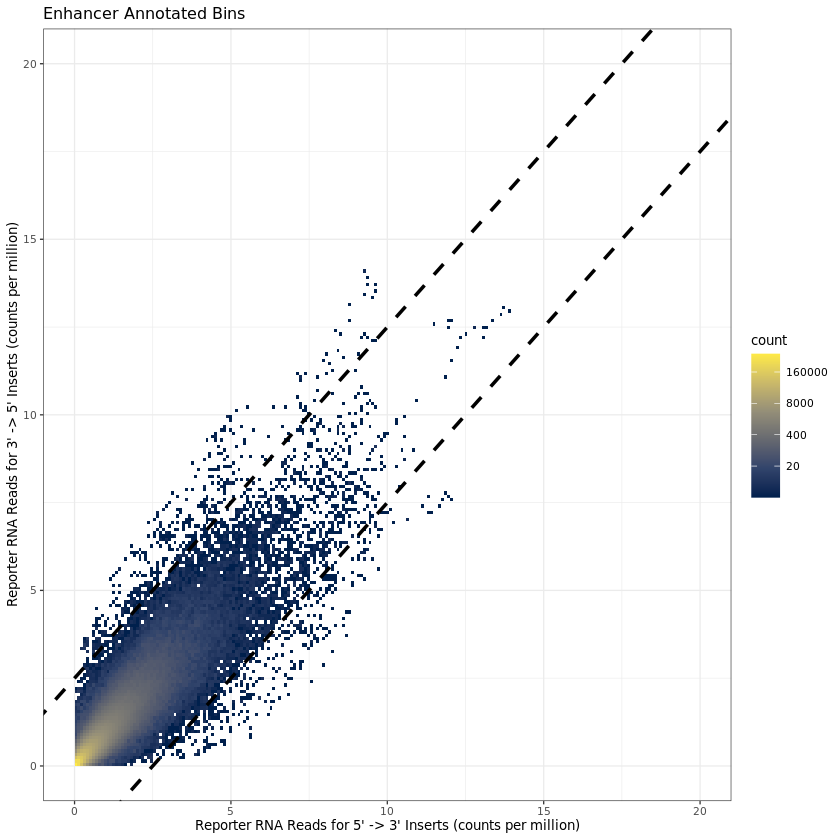

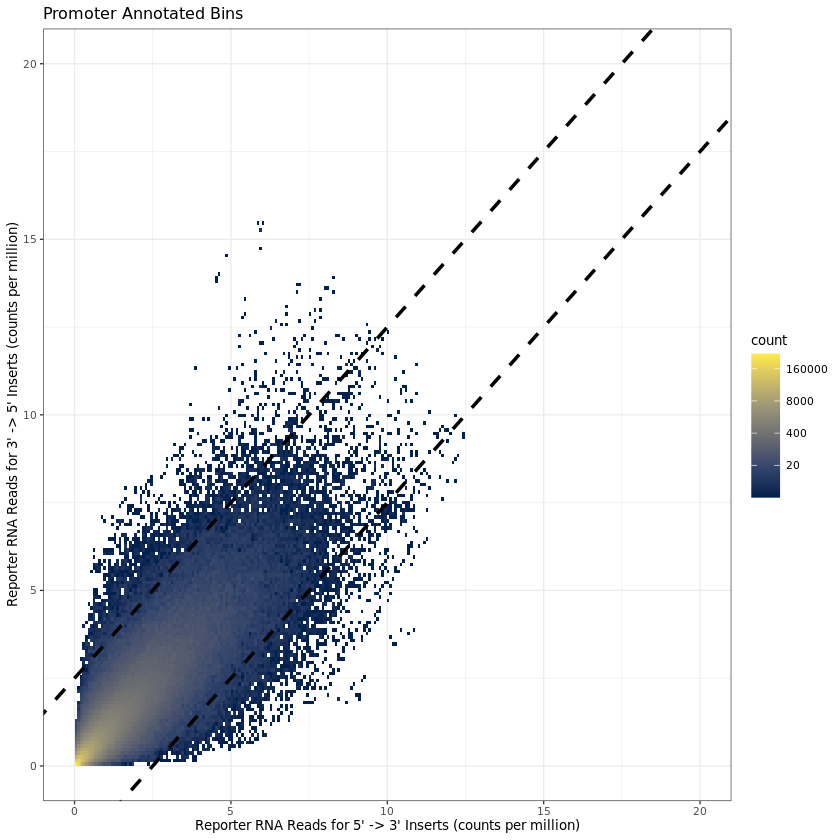

In [40]:
#Make scatterplots.
library(ggplot2)

scatter_enhc <- ggplot(cpm_enhc, aes(x=`5_3_cpm`, y=`3_5_cpm`)) +
       geom_bin2d(bins=150) +
       geom_abline(slope = 1, intercept = -2.5, linetype = "dashed", lwd = 1, color = "black") +
           geom_abline(slope = 1, intercept = 2.5, linetype = "dashed", lwd = 1, color = "black") +
       labs(x = "Reporter RNA Reads for 5' -> 3' Inserts (counts per million)", 
            y="Reporter RNA Reads for 3' -> 5' Inserts (counts per million)") +
       scale_fill_viridis_c(trans = "log", breaks = c(0, 20, 400, 8000, 160000), option = "cividis") +
       ggtitle("Enhancer Annotated Bins") +
       theme_bw(base_size = 8) +
       coord_cartesian(xlim = c(0, 20), ylim = c(0, 20))
       
scatter_prom <- ggplot(cpm_prom, aes(x=`5_3_cpm`, y=`3_5_cpm`)) +
       geom_bin2d(bins=150) +
       geom_abline(slope = 1, intercept = -2.5, linetype = "dashed", lwd = 1, color = "black") +
           geom_abline(slope = 1, intercept = 2.5, linetype = "dashed", lwd = 1, color = "black") +
       labs(x = "Reporter RNA Reads for 5' -> 3' Inserts (counts per million)", 
            y="Reporter RNA Reads for 3' -> 5' Inserts (counts per million)") +
       scale_fill_viridis_c(trans = "log", breaks = c(0, 20, 400, 8000, 160000), option = "cividis") +
       ggtitle("Promoter Annotated Bins") +
       theme_bw(base_size = 8)+
       coord_cartesian(xlim = c(0, 20), ylim = c(0, 20))

scatter_enhc
scatter_prom

#Save as pdf.
ggsave(plot = scatter_enhc, paste0(dir,"/enhancer_correlation.pdf"), width = 4, height = 4)
ggsave(plot = scatter_prom, paste0(dir,"/prom_correlation.pdf"), width = 4, height = 4)

These correlations and plots suggests there are not global effects of promoter oreintation on RNA read depth. It is slightly more balooned than the enhancer, but not all that much. This concludes that there is no global effect from orientation. Next look specifically at active and silent bins called. 


In [5]:
#read in active and silent bins and intersect with these. 
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink'

#read tsvs into R. Yes I realize I spelled specific wrong..  
active_bins <- read_tsv(paste0(dir, "/active_bins.bed"),
                       col_names = c("Chr", "Start", "End", "Bin_ID", "Score", "Strand"), 
                       col_types = "ciicnf")

silent_bins <- read_tsv(paste0(dir, "/silent_bins.bed"),
                       col_names = c("Chr", "Start", "End", "Bin_ID", "Score", "Strand"), 
                       col_types = "ciicnf")

head(active_bins)
head(silent_bins)

Chr,Start,End,Bin_ID,Score,Strand
<chr>,<int>,<int>,<chr>,<dbl>,<fct>
chr1,778350,778400,bin_26,1.4839023,.
chr1,778360,778410,bin_27,1.3938926,.
chr1,778370,778420,bin_28,1.1696538,.
chr1,778380,778430,bin_29,1.1645494,.
chr1,778390,778440,bin_30,1.0511625,.
chr1,778400,778450,bin_31,0.9988175,.


Chr,Start,End,Bin_ID,Score,Strand
<chr>,<int>,<int>,<chr>,<dbl>,<fct>
chr1,827584,827634,bin_237,-0.7545407,.
chr1,827594,827644,bin_238,-0.8028934,.
chr1,827604,827654,bin_239,-2.0615489,.
chr1,827614,827664,bin_240,-2.3731086,.
chr1,827624,827674,bin_241,-2.9224911,.
chr1,827634,827684,bin_242,-1.4922807,.


In [12]:
#inner_join promoter counts to active and silent seperately.
prom_act <- inner_join(cpm_prom, active_bins, by = c("Chr"="Chr", "Start"="Start", "End"="End"))
prom_sil <- inner_join(cpm_prom, silent_bins, by = c("Chr"="Chr", "Start"="Start", "End"="End"))
enhc_act <- inner_join(cpm_enhc, active_bins, by = c("Chr"="Chr", "Start"="Start", "End"="End"))
enhc_sil <- inner_join(cpm_enhc, silent_bins, by = c("Chr"="Chr", "Start"="Start", "End"="End"))

head(prom_act)
nrow(prom_act)
nrow(prom_sil)
nrow(enhc_act)
nrow(enhc_sil)

Name_ID,Chr,Start,End,Strand.x,Length,5_3,3_5,5_3_cpm,3_5_cpm,Bin_ID,Score,Strand.y
<chr>,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<fct>
name_4,chr1,778350,778400,.,50,349,206,0.5138078,0.3023445,bin_26,1.4839023,.
name_5,chr1,778360,778410,.,50,358,210,0.5270579,0.3082153,bin_27,1.3938926,.
name_6,chr1,778370,778420,.,50,395,298,0.5815303,0.4373722,bin_28,1.1696538,.
name_7,chr1,778380,778430,.,50,415,324,0.6109749,0.4755321,bin_29,1.1645494,.
name_8,chr1,778390,778440,.,50,420,339,0.6183361,0.4975475,bin_30,1.0511625,.
name_9,chr1,778400,778450,.,50,430,339,0.6330583,0.4975475,bin_31,0.9988175,.


[1] 124227

[1] 296016

[1] 127668

[1] 43721

In [13]:
#Calculate correlations:
TH_correlation <- function (df) {
    print("number of regions")
    print(nrow(df))
    print(cor.test(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"))
    print(cor.test(df$`5_3_cpm`, df$`3_5_cpm`, method = "pearson"))
}

print("Active Promoter")
TH_correlation(df = prom_act)
print("Silent Promoter")
TH_correlation(df = prom_sil)
print("Active Enhancer")
TH_correlation(df = enhc_act)
print("Silent Enhancer")
TH_correlation(df = enhc_sil)


[1] "Active Promoter"
[1] "number of regions"
[1] 124227


Warning message in cor.test.default(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df$`5_3_cpm` and df$`3_5_cpm`
S = 3.3434e+13, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8953607 


	Pearson's product-moment correlation

data:  df$`5_3_cpm` and df$`3_5_cpm`
t = 747.9, df = 124225, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9035679 0.9055891
sample estimates:
      cor 
0.9045836 

[1] "Silent Promoter"
[1] "number of regions"
[1] 296016


Warning message in cor.test.default(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df$`5_3_cpm` and df$`3_5_cpm`
S = 7.7716e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8202305 


	Pearson's product-moment correlation

data:  df$`5_3_cpm` and df$`3_5_cpm`
t = 730.16, df = 296014, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8005767 0.8031489
sample estimates:
      cor 
0.8018666 

[1] "Active Enhancer"
[1] "number of regions"
[1] 127668


Warning message in cor.test.default(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df$`5_3_cpm` and df$`3_5_cpm`
S = 7.9136e+13, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7718199 


	Pearson's product-moment correlation

data:  df$`5_3_cpm` and df$`3_5_cpm`
t = 794.21, df = 127666, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9110320 0.9128788
sample estimates:
    cor 
0.91196 

[1] "Silent Enhancer"
[1] "number of regions"
[1] 43721


Warning message in cor.test.default(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df$`5_3_cpm` and df$`3_5_cpm`
S = 2.5449e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8172913 


	Pearson's product-moment correlation

data:  df$`5_3_cpm` and df$`3_5_cpm`
t = 312.53, df = 43719, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8282258 0.8340227
sample estimates:
      cor 
0.8311468 



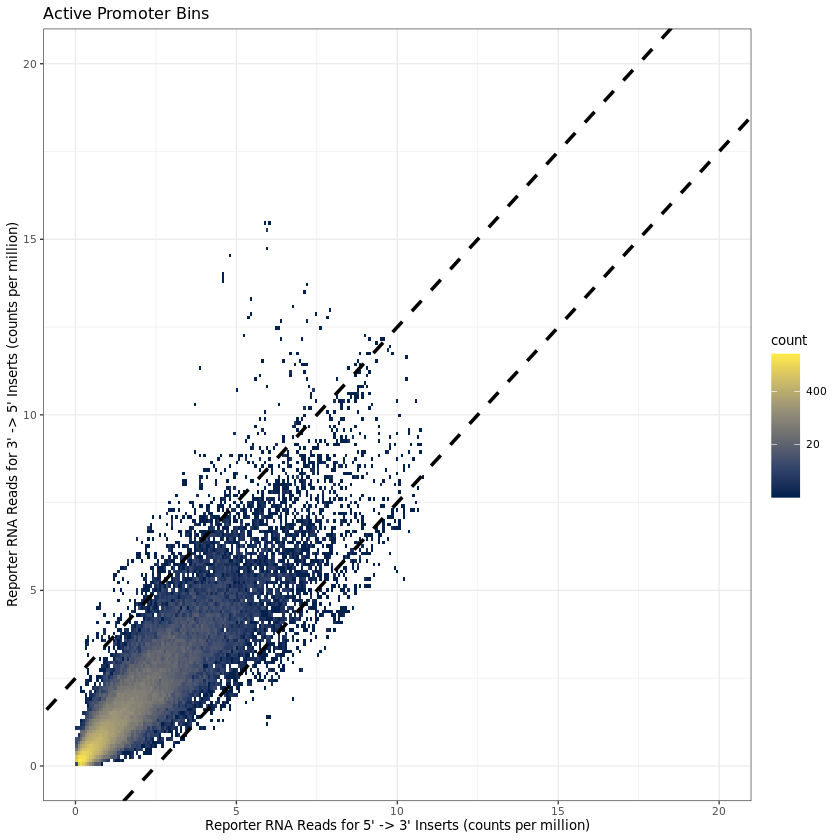

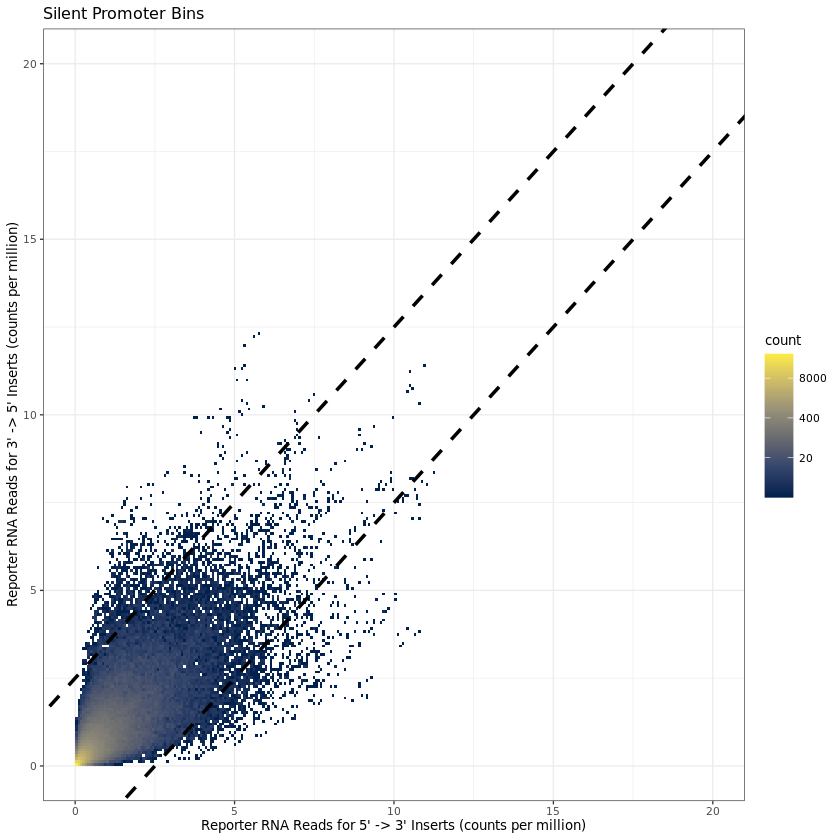

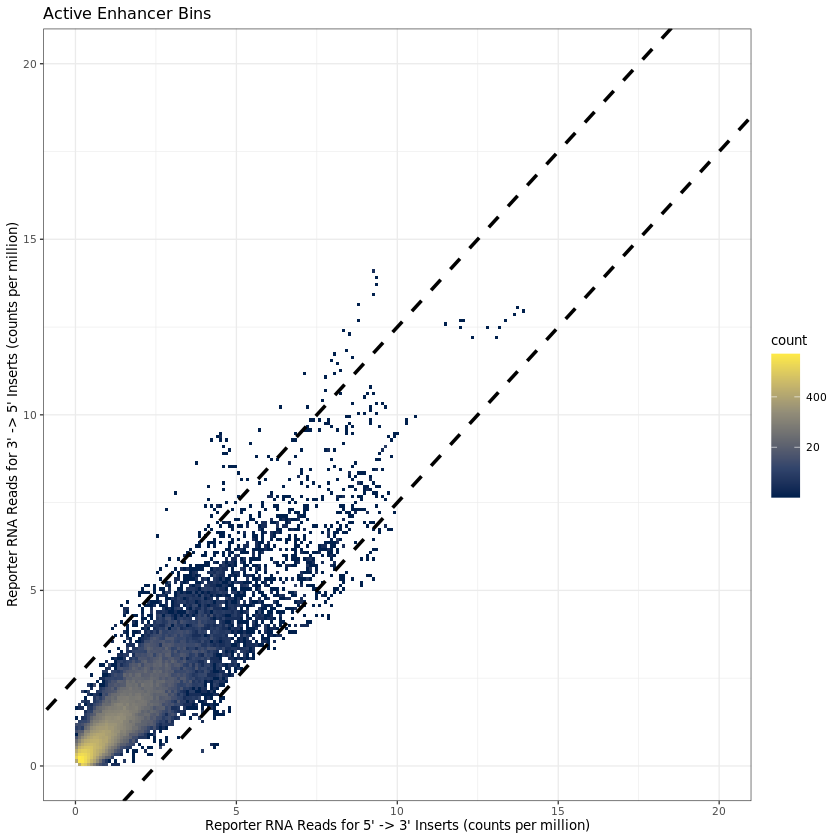

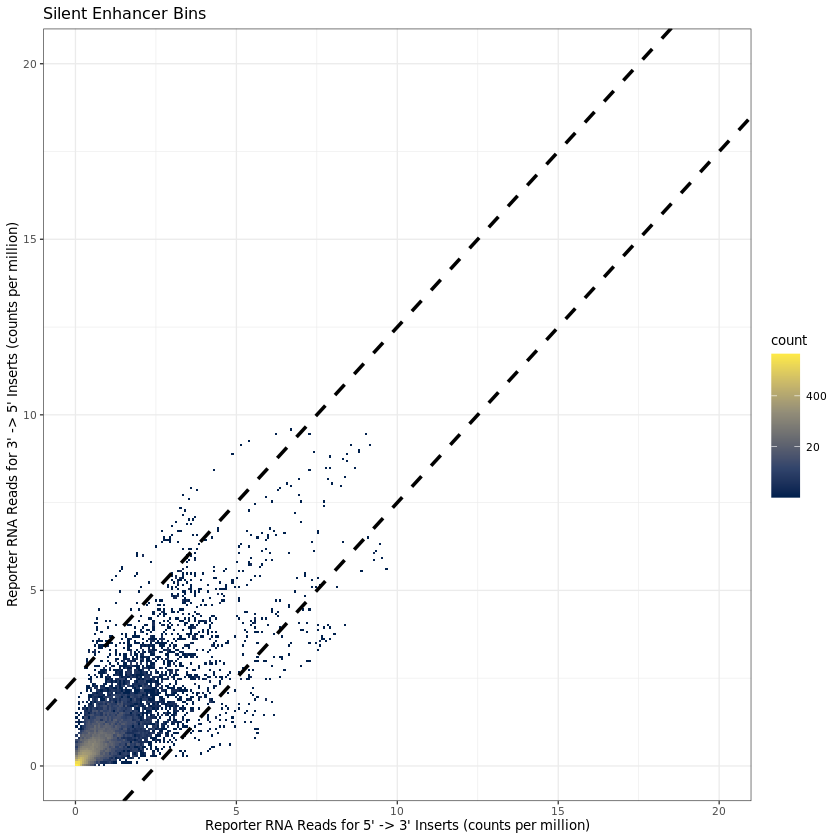

In [38]:
#Make scatterplots.
library(ggplot2)

#my function
TH_scatterplot <- function(df, title, viridis_option = "viridis") {
    p <- ggplot(df, aes(x=`5_3_cpm`, y=`3_5_cpm`)) +
           geom_bin2d(bins=150) +
           geom_abline(slope = 1, intercept = -2.5, linetype = "dashed", lwd = 1, color = "black") +
           geom_abline(slope = 1, intercept = 2.5, linetype = "dashed", lwd = 1, color = "black") +
           labs(x = "Reporter RNA Reads for 5' -> 3' Inserts (counts per million)", 
                y="Reporter RNA Reads for 3' -> 5' Inserts (counts per million)") +
           scale_fill_viridis_c(trans = "log", breaks = c(0, 20, 400, 8000, 160000), option = viridis_option) +
           ggtitle(title) +
           theme_bw(base_size = 8) +
           coord_cartesian(xlim = c(0, 20), ylim = c(0, 20))
    return(p)
}

#run function
prom_act_p <- TH_scatterplot(prom_act, title = "Active Promoter Bins", viridis_option = "cividis")
prom_sil_p <- TH_scatterplot(prom_sil, title = "Silent Promoter Bins", viridis_option = "cividis")
enhc_act_p <- TH_scatterplot(enhc_act, title = "Active Enhancer Bins", viridis_option = "cividis")
enhc_sil_p <- TH_scatterplot(enhc_sil, title = "Silent Enhancer Bins", viridis_option = "cividis")

#view plots
prom_act_p
prom_sil_p
enhc_act_p 
enhc_sil_p 

#Save as pdfs.
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'
ggsave(plot = prom_act_p, paste0(dir,"/active-promoter_correlation.pdf"), width = 4, height = 4)
ggsave(plot = prom_sil_p, paste0(dir,"/silent-promoter_correlation.pdf"), width = 4, height = 4)
ggsave(plot = enhc_act_p, paste0(dir,"/active-enhancer_correlation.pdf"), width = 4, height = 4)
ggsave(plot = enhc_sil_p, paste0(dir,"/silent-enhancer_correlation.pdf"), width = 4, height = 4)

The interpretation at this point is that RNA output is not biased by orientation for all bins and active and silent bins. However, there looks like there may be a subset of regions in the silent proximal set that have promoter bias. The next step will be to subset these regions by some threshold and report number. We could further ask does the reported bias match the orientation of the element in the genome. 

## Count bins with orientation bias

In [41]:
#total number of bins in each
nrow(cpm_prom)
nrow(cpm_enhc)
nrow(prom_act)
nrow(prom_sil)
nrow(enhc_act)
nrow(enhc_sil)

#This counts bins when the difference between orientations is 2.5 counts or greater. 
filter(cpm_prom, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow()
filter(cpm_enhc, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow()
filter(prom_act, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow()
filter(prom_sil, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow()
filter(enhc_act, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow()
filter(enhc_sil, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow()

#This determines proportion of bins when the difference between orientations is 2.5 counts or greater. 
filter(cpm_prom, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow() / nrow(cpm_prom)
filter(cpm_enhc, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow() / nrow(cpm_enhc)
filter(prom_act, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow() / nrow(prom_act)
filter(prom_sil, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow() / nrow(prom_sil)
filter(enhc_act, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow() / nrow(enhc_act)
filter(enhc_sil, abs(`5_3_cpm` - `3_5_cpm`) > 2.5) %>% nrow() / nrow(enhc_sil)

[1] 2382142

[1] 3827480

[1] 124227

[1] 296016

[1] 127668

[1] 43721

[1] 7082

[1] 979

[1] 1105

[1] 2609

[1] 229

[1] 254

[1] 0.002972955

[1] 0.0002557819

[1] 0.008895007

[1] 0.008813713

[1] 0.001793715

[1] 0.005809565

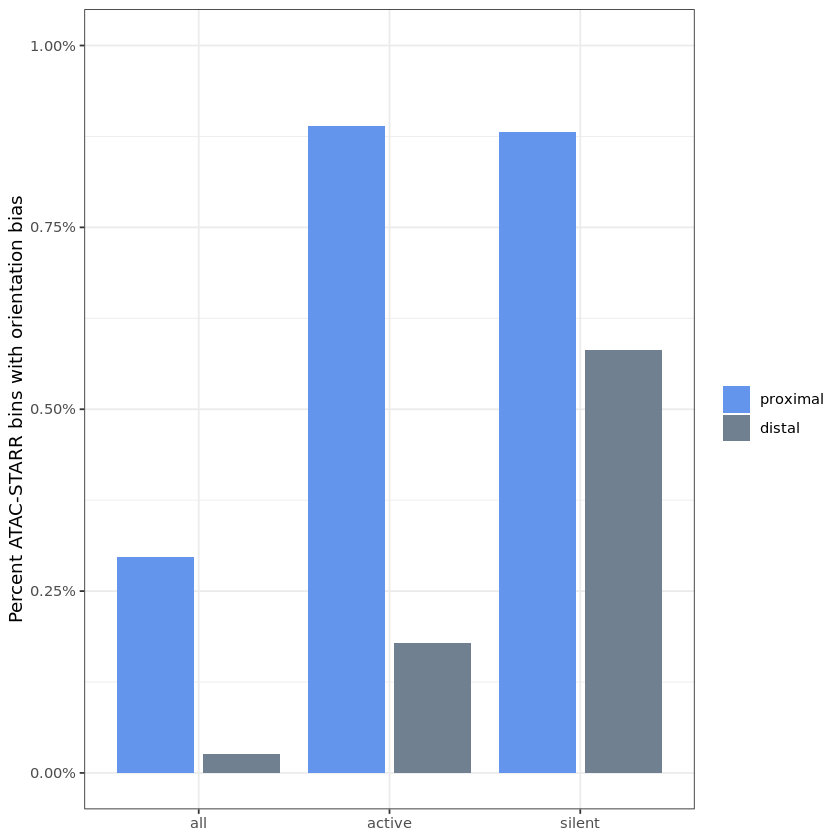

In [4]:
library(ggplot2)
df <- data.frame(value = c(0.00297, 0.000256, 0.00890, 0.00881, 0.00179, 0.00581),
                 element_type = c("proximal", "distal", "proximal", "proximal", "distal", "distal"),
                 regulatory_state = c("all", "all", "active", "silent", "active", "silent"))

df$regulatory_state <- factor(df$regulatory_state, levels = c("all", "active", "silent"))
df$element_type <- factor(df$element_type, levels = c("proximal", "distal"))

p <- ggplot(df, aes(x=regulatory_state, y=value, fill=element_type)) + 
    geom_col(position = "dodge2") +
    scale_fill_manual(values = c("cornflowerblue", "slategray")) +
    scale_y_continuous(labels = scales::percent) +
    ylab("Percent ATAC-STARR bins with orientation bias") +
    theme_bw() +
    theme(legend.title = element_blank(), axis.title.x = element_blank()) +
    coord_cartesian(ylim = c(0, 0.01))

p

res_dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'
ggsave(p, filename = paste0(res_dir, "/orientation_bias_bar.pdf"), device = cairo_pdf, width = 4, height = 2)

# __Differences in number of active regions between ATAC-STARR and HiDRA__

With the first point answered, let's move on to the second revision: 

2. We were also asked to investigate the differences in number of active regions called between ATAC-STARR and hiDRA. In my opinion, the likely answer is that this is driven by replicate number. However we should rule out several possibilities first. First, we should call HiDRA peaks using our bin method approach and compare to the peaks they call. This will tell us about any differences in data analysis. Second, we should identify what is called differently between the two and characterize those regions. My hypothesis is that HiDRA calls too many peaks as active. We could argue the correct number using eRNA data, the DNs identified in HiDRA, and other STARR-seq data. 

To address this, first call active bins for hiDRA data to see how the number called compares. I need to first get hiDRA data and process it in the same way as I do ATAC-STARR.  

## Compare Active Region Bed files
While wating for fastq-dump to do its thing (see below), I wanted to ask another question. What are the differnces between our active regions, their active regaions, and their DNs? 

Start with a simple intersect to see overlap and then make a euler plot. 

In [3]:
%%bash

# I have their processed data in another directory. 
hiDRA="/data/hodges_lab/public_data/GM12878/obtained_as_raw_files/hiDRA_GM12878_2018-kellis"
AS="/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink"

#print total number opf regions for each
wc -l ${hiDRA}/hiDRA_driver-nucleotides_hg38.sort.bed
wc -l ${hiDRA}/hiDRA_active_regions.hg38.sort.bed
wc -l ${AS}/active_regions.bed

#Do bedtools jaccard to get number of intersections between region sets. 

#DNs vs hidra active
bedtools jaccard -a ${hiDRA}/hiDRA_driver-nucleotides_hg38.sort.bed -b ${hiDRA}/hiDRA_active_regions.hg38.sort.bed

#DNs vs AS
bedtools jaccard -a ${hiDRA}/hiDRA_driver-nucleotides_hg38.sort.bed -b ${AS}/active_regions.bed

#AS vs hidra active
bedtools jaccard -b ${hiDRA}/hiDRA_active_regions.hg38.sort.bed -a ${AS}/active_regions.bed

#Shared among all three?
bedtools intersect -u -a ${hiDRA}/hiDRA_driver-nucleotides_hg38.sort.bed -b ${hiDRA}/hiDRA_active_regions.hg38.sort.bed | \
bedtools jaccard -b ${AS}/active_regions.bed -a - 

12945 /data/hodges_lab/public_data/GM12878/obtained_as_raw_files/hiDRA_GM12878_2018-kellis/hiDRA_driver-nucleotides_hg38.sort.bed
66238 /data/hodges_lab/public_data/GM12878/obtained_as_raw_files/hiDRA_GM12878_2018-kellis/hiDRA_active_regions.hg38.sort.bed
30078 /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/active_regions.bed
intersection	union	jaccard	n_intersections
600739	23543103	0.0255166	8931
intersection	union	jaccard	n_intersections
124520	4793107	0.025979	2724
intersection	union	jaccard	n_intersections
1482285	25659250	0.0577681	9980
intersection	union	jaccard	n_intersections
112447	4451351	0.0252613	2467


##### Results
DNs = 12,945  
hidra active = 66,238  
ATAC-STARR active = 30,078

DNs + hidra active = 8,931

DNs + AS = 2,724

hidra active + AS = 9,980

All three = 2,467

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



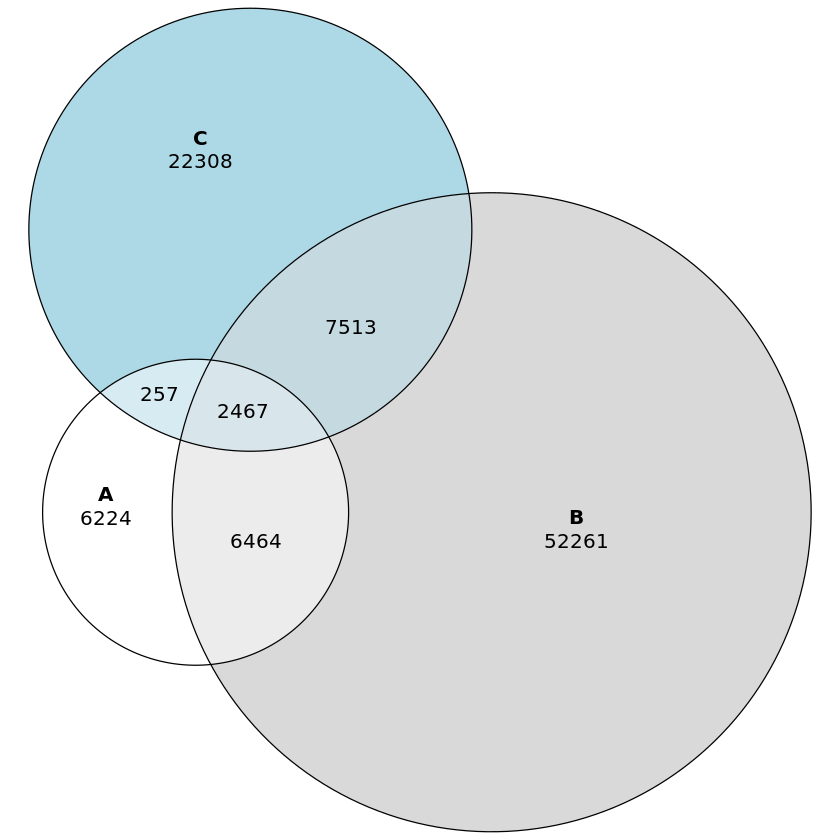

In [1]:
#make euler plot with values above. 
library(tidyverse)
library(eulerr)

#set names to variables
A_name <- "`Wang Driver Nucleotides`"
B_name <- "`Wang Active Regions`"
C_name <- "Hansen Active Regions"

#set values to variables:
A <- 12945
B <- 66238
C <- 30078
A_B <- 8931
A_C <- 2724
B_C <- 9980
A_B_C <- 2467

#make named list using variables above. This shouldn't change for all 3-way comparisons. 
combo <- c(A = A-(A_B-A_B_C)-(A_C-A_B_C), B = B-(A_B-A_B_C)-(B_C-A_B_C), C = C-(A_C-A_B_C)-(B_C-A_B_C), 
           `A&B` = A_B-A_B_C, `A&C` = A_C-A_B_C, `B&C` = B_C-A_B_C, 
          `A&B&C` = A_B_C)

eul <- plot(euler(combo), quantities = TRUE) 
eul

#save and edit in illustrator. 
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions'
ggsave(plot = eul, paste0(dir,"/euler-plot.pdf"), width = 3, height = 3)

##### Discussion
Now the question is what is different about these three gene sets. There are a few possibilities. 

1. Technical differences such as more replicates
2. Computational differences such as use of DESeq2 shrinkage
3. Biological differnces such as use of a different promoter that drives different regulatory activities

How best do we identify the key difference? If it is biological it should be obvious based on GO or motif enrichment. 

The level of disagreement we see hints to something more systemic. It will be better to analyze their data from the fastq step. That will rule out any computational differences. This process is carried out below. 

## Compare active regions using raw sequencing data

### Download and process HiDRA data

#### Step 1: Download fastqs from SRA

The GEO number is GSE104001. They have 5 replicates for RNA and DNA. Each replicate has 4 runs. 

DNA Rep1 - SRR6050484 | SRR6050485 | SRR6050486	| SRR6050487  
DNA Rep2 - SRR6050488 | SRR6050489 | SRR6050490	| SRR6050491  
DNA Rep3 - SRR6050492 | SRR6050493 | SRR6050494	| SRR6050495   
DNA Rep4 - SRR6050496 | SRR6050497 | SRR6050498	| SRR6050499   
DNA Rep5 - SRR6050500 | SRR6050501 | SRR6050502	| SRR6050503   

RNA Rep1 - SRR6050504 | SRR6050505 | SRR6050506	| SRR6050507  
RNA Rep2 - SRR6050508 | SRR6050509 | SRR6050510 | SRR6050511   
RNA Rep3 - SRR6050512 | SRR6050513 | SRR6050514 | SRR6050515   
RNA Rep4 - SRR6050516 | SRR6050517 | SRR6050518 | SRR6050519   
RNA Rep5 - SRR6050520 | SRR6050521 | SRR6050522 | SRR6050523  

In [ ]:
cd /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/fastq

module load SRA-Toolkit/2.9.6-1-centos_linux64

#I'm using code from here: https://edwards.sdsu.edu/research/fastq-dump/
for ID in {6050484..6050523}
do
fastq-dump --gzip --readids --read-filter pass --dumpbase --split-3 --clip SRR${ID}
done

The above code did not reliably run, so I made a slurm script called "fastq-dump-hidra.slrm" and submitted the above code as a three day job. I started at 6050486 because 6050484 and 6050485 seemed to download fine. 

In [3]:
cat /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/fastq/fastq-dump-hidra.slrm

#!/bin/bash
#SBATCH --mem=16G
#SBATCH --time=03-00:00:00
#SBATCH --mail-user=tyler.j.hansen@vanderbilt.edu
#SBATCH --mail-type=ALL
##########################
#This is a script to download hiDRA data. It didn't run reliably on jupyter so submitting the code from the notebook as a script.
#Importantly the first two (6050484 and 6050485) ran fine, so starting at 6050486 here. 
##########################
cd /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/fastq

module load SRA-Toolkit/2.9.6-1-centos_linux64

#I'm using code from here: https://edwards.sdsu.edu/research/fastq-dump/
for ID in {6050486..6050523}
do
fastq-dump --gzip --readids --read-filter pass --dumpbase --split-3 --clip SRR${ID}
done


#### Step 2: Process fastqs to filtered bams

Now we need to trim and map the hiDRA reads to hg38. Do this with a script containing the code I used for my data. This script is a copy of fastq_processing.slrm script in my github. 

In [2]:
cat /data/hodges_lab/ATAC-STARR_V2/bin/fastq_processing/fastq_processing_TH_HiDRA.slrm

#move reads to new directory. 

mv /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/fastq/*.fastq.gz \
/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/data/fastq/raw_reads

#execute script
sbatch /data/hodges_lab/ATAC-STARR_V2/bin/fastq_processing/fastq_processing_TH_HiDRA.slrm

#!/bin/bash
#SBATCH --mail-user=tyler.j.hansen@vanderbilt.edu
#SBATCH --mail-type=ALL
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=12
#SBATCH --time=3-00:00:00
#SBATCH --mem=64G
#######################################################                                                                                                                 
#Tyler Hansen - 2020-08-12

#This is a slurm script for processing fastq files.                                                                                                                     
#There are seven functions that each carry out discrete steps of this processing. 
#These functions are all wrapped into one master function called process_fastq.

#This inputs fastq files and ouputs intermediate and processed bam files. 
#It also generates several results, including trimming reports, fastqc, and flagstat results. 
#These are stored in a data-labeled folder generated within the script within the results directory. 

#Fo

        done
    fi
}

#Master function
process_fastq () #arg1=project_directory_path #arg2=input_read1 #arg3=input_read2 #arg4=output_filename #arg5=genome (hg38 or rheMac10)
{
    cd $1
    prep_filesystem
    cd $1
    trim $2 $3 $4
    cd $1
    map $4 $5
    cd $1
    filter $4 $5
    cd $1
    remove_duplicates $4
    cd $1
    sort_file_index $4
    cd $1
    flagstat $4 $5
}

### Execute Functions ###
# syntax: process_fastq /data/hodges_lab/ATAC-STARR_V2 <input_read1> <input_read2> <output_filename> <genome>

HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'

process_fastq $HIDRA SRR6050484_pass_1.fastq.gz SRR6050484_pass_2.fastq.gz  HiDRA_DNA_Rep_1A hg38
process_fastq $HIDRA SRR6050485_pass_1.fastq.gz SRR6050485_pass_2.fastq.gz  HiDRA_DNA_Rep_1B hg38
process_fastq $HIDRA SRR6050486_pass_1.fastq.gz SRR6050486_pass_2.fastq.gz  HiDRA_DNA_Rep_1C hg38
process_fastq $HIDRA SRR6050487_pass_1.fastq.gz SRR6050487_pass_2.fastq.gz  HiDRA_D

: 1

#### Step 3: Merge Technical Replicates

With the processing done, check the QC and then proceed to merge technical replicate files into biological replicates (for example 1A-1D). With the merged deduplicated files call chrAcc peaks using genrich.

In [3]:
module restore tools

HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'

#merge technical replicates for DNA:
for i in filtered unique
do
    for j in DNA_Rep_1 DNA_Rep_2 DNA_Rep_3 DNA_Rep_4 DNA_Rep_5 
    do
        #Merge reps and pos-sort. Both merge and sort require ouput name as first file for some stupid reason. 
        # Here I use "-" to pipe to sort. 
        samtools merge -@ 3 - \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}A.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}B.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}C.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}D.${i}.pos-sorted.bam | \
        samtools sort -@ 3 -o ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}.pos-sorted.${i}.bam -
        
        #make an n-sorted version
        samtools sort -n -@ 3 -o ${HIDRA}/data/bams/n-sorted/HiDRA_${j}.n-sorted.${i}.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}.pos-sorted.${i}.bam
        
        done
done


Restoring modules from user's tools
[bam_sort_core] merging from 33 files and 3 in-memory blocks...
[bam_sort_core] merging from 33 files and 3 in-memory blocks...
[bam_sort_core] merging from 24 files and 3 in-memory blocks...
[bam_sort_core] merging from 24 files and 3 in-memory blocks...
[bam_sort_core] merging from 24 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 24 files and 3 in-memory blocks...
[bam_sort_core] merging from 24 files and 3 in-memory blocks...
[bam_sort_core] merging from 39 files and 3 in-memory blocks...
[bam_sort_core] merging from 39 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam

In [1]:
module restore tools

HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'

#merge technical replicates for RNA:
for i in filtered unique
do
    for j in RNA_Rep_1 RNA_Rep_2 RNA_Rep_3 RNA_Rep_4 RNA_Rep_5 
    do
        #Merge reps and pos-sort. Both merge and sort require ouput name as first file for some stupid reason. 
        # Here I use "-" to pipe to sort. 
        samtools merge -@ 3 - \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}A.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}B.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}C.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}D.${i}.pos-sorted.bam | \
        samtools sort -@ 3 -o ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}.pos-sorted.${i}.bam -
        
        #make an n-sorted version
        samtools sort -n -@ 3 -o ${HIDRA}/data/bams/n-sorted/HiDRA_${j}.n-sorted.${i}.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}.pos-sorted.${i}.bam
        
        done
done


#move tech reps to a new folder to clean up. 
for sort in pos-sorted n-sorted 
do
    mv ${HIDRA}/data/bams/${sort}/*A.* ${HIDRA}/data/bams/${sort}/tech-reps
    mv ${HIDRA}/data/bams/${sort}/*B.* ${HIDRA}/data/bams/${sort}/tech-reps
    mv ${HIDRA}/data/bams/${sort}/*C.* ${HIDRA}/data/bams/${sort}/tech-reps
    mv ${HIDRA}/data/bams/${sort}/*D.* ${HIDRA}/data/bams/${sort}/tech-reps
done    

Restoring modules from user's tools
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 27 files and 3 in-memory blocks...
[bam_sort_core] merging from 30 files and 3 in-memory blocks...
[bam_sort_core] merging from 30 files and 3 in-memory blocks...
[bam_sort_core] merging from 30 files and 3 in-memory blocks...
[bam_sort_core] merging from 30 files and 3 in-memory blocks...
[bam_sort_core] merging from 30 files and 3 in-memory blocks...
[bam

### Call ChrAcc peaks using HiDRA bams

Now call ChrAcc peaks with unique DNA files using genrich. 

#### Try 1 - ran into readname issue

In [3]:
HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'

mkdir ${HIDRA}/data/chrAcc-peaks

/home/hansetj1/Genrich/Genrich -t ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.unique.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_2.n-sorted.unique.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_3.n-sorted.unique.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_4.n-sorted.unique.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_5.n-sorted.unique.bam \
    -o ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich.narrowPeak -j -v

#filter result for 0.0001 qvalue. Use awk to filter the ninth column, which corresponds to the -log10(qvalue).
awk 'BEGIN{OFS=FS="\t"}{if ($9>4) print}' ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich.narrowPeak > \
${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_0.0001-qvalue.narrowPeak

#print count of regions:
wc -l ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_0.0001-qvalue.narrowPeak

mkdir: cannot create directory ‘/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/data/chrAcc-peaks’: File exists
Processing experimental file #0: /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.unique.bam
  BAM records analyzed:  148347222
    Paired alignments:   148347222
      "orphan" alns:     148347222
    Unpaired alignments:         0
  Fragments analyzed:            0
    Full fragments:              0
    ATAC-seq cut sites:          0
      (expanded to length 100bp)
Error! Experimental sample has no analyzable fragments
awk: cmd. line:1: fatal: cannot open file `/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/data/chrAcc-peaks/HiDRA_DNA_genrich.narrowPeak' for reading (No such file or directory)
0 /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/data/chrAcc-peaks/HiDR

##### Problem
We have a lot of orphan reads and genrich cannot call peaks using orphan reads. Figure out what is going on by looking at the bam files. 

In [9]:
HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'
ls ${HIDRA}/data/bams/n-sorted/
module restore tools
samtools view ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.filtered.bam | head
samtools view /data/hodges_lab/ATAC-STARR_V2/data/bams/n-sorted/GM12878inGM12878_DNA_Rep1.unique.n-sorted.bam | head

HiDRA_DNA_Rep_1.n-sorted.filtered.bam  HiDRA_RNA_Rep_1.n-sorted.unique.bam
HiDRA_DNA_Rep_1.n-sorted.unique.bam    HiDRA_RNA_Rep_2.n-sorted.filtered.bam
HiDRA_DNA_Rep_2.n-sorted.filtered.bam  HiDRA_RNA_Rep_2.n-sorted.unique.bam
HiDRA_DNA_Rep_2.n-sorted.unique.bam    HiDRA_RNA_Rep_3.n-sorted.filtered.bam
HiDRA_DNA_Rep_3.n-sorted.filtered.bam  HiDRA_RNA_Rep_3.n-sorted.unique.bam
HiDRA_DNA_Rep_3.n-sorted.unique.bam    HiDRA_RNA_Rep_4.n-sorted.filtered.bam
HiDRA_DNA_Rep_4.n-sorted.filtered.bam  HiDRA_RNA_Rep_4.n-sorted.unique.bam
HiDRA_DNA_Rep_4.n-sorted.unique.bam    HiDRA_RNA_Rep_5.n-sorted.filtered.bam
HiDRA_DNA_Rep_5.n-sorted.filtered.bam  HiDRA_RNA_Rep_5.n-sorted.unique.bam
HiDRA_DNA_Rep_5.n-sorted.unique.bam    tech-reps
HiDRA_RNA_Rep_1.n-sorted.filtered.bam
Restoring modules from user's tools
SRR6050484.1.1	99	chr13	40652319	42	36M	=	40652640	357	TCTGTCGCCCAGGCTGGAGTGTAGCGGCACGATCTC	AAAAAEEEEEEEEEEEEEEEEEEEEEEEAEEEEEEE	AS:i:-5	XN:i:0	XM:i:1	XO:i:0	XG:i:0	NM:i:1	MD:Z:29A6	YS:i:0	YT:Z:

#### Fix readname issue with Tim's Awk function
I forgot how f-ing annoying fastq-dump is sometimes. They add a read 1 and read 2 identifier to the read names (see first file above). Use an awesome awk command that tim wrote to remove the last two digits of the first column to correct the bam files.

I wrote a script to do this. 

In [14]:
#Test the awk command to see if it works
samtools view ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.filtered.bam | head -n 6

samtools view ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.filtered.bam | \
awk 'BEGIN{OFS=FS="\t"}{$1=substr($1,1,length($1)-2);print}' - | head -n 6

SRR6050484.1.1	99	chr13	40652319	42	36M	=	40652640	357	TCTGTCGCCCAGGCTGGAGTGTAGCGGCACGATCTC	AAAAAEEEEEEEEEEEEEEEEEEEEEEEAEEEEEEE	AS:i:-5	XN:i:0	XM:i:1	XO:i:0	XG:i:0	NM:i:1	MD:Z:29A6	YS:i:0	YT:Z:CP
SRR6050484.1.2	147	chr13	40652640	42	36M	=	40652319	-357	CAACTCTATCCTGAAGGTTAGAGAAGAGAAAAAACC	EEEEEEEEEEEEEEEEEAEEEEEEEEEEEEEAAAAA	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:36	YS:i:-5	YT:Z:CP
SRR6050484.4.1	99	chr3	42883015	42	37M	=	42883403	424	GTCTCTGACTTGCTATGTTAGTGATTTTATGCACCCA	AAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEAEAAE	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:37	YS:i:0	YT:Z:CP
SRR6050484.4.2	147	chr3	42883403	42	36M	=	42883015	-424	GTTTCCCCATACTGTTCTCGTGGTAGTGAGTAATTC	EEEEEEEEEEEEEEEEEEEEAEEEEEAEEEEAAAAA	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:36	YS:i:0	YT:Z:CP
SRR6050484.8.1	83	chr3	44861480	42	36M	=	44861196	-320	AGGCATCTCTTGGTCCGGCGGTCCTCAGGCTGGAGG	EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAAAAA	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:36	YS:i:0	YT:Z:CP
SRR6050484.8.2	163	chr

In [34]:
#execute this script:
cat HiDRA_fixbam.slrm

#!/bin/bash
##SBATCH --mail-user=tyler.j.hansen@vanderbilt.edu
##SBATCH --mail-type=ALL
##SBATCH --nodes=1
##SBATCH --ntasks=1
##SBATCH --cpus-per-task=6
##SBATCH --time=24:00:00
##SBATCH --mem=32G

module restore tools 

#now make a loop to process the bams. Make sure to add back the header. 

for FILE in DNA_Rep_1 DNA_Rep_2 DNA_Rep_3 DNA_Rep_4 DNA_Rep_5 RNA_Rep_1 RNA_Rep_2 RNA_Rep_3 RNA_Rep_4 RNA_Rep_5
do
    for TYPE in filtered unique
    do
        #define files:
        HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'
        IN=${HIDRA}'/data/bams/n-sorted/HiDRA_'${FILE}'.n-sorted.'${TYPE}'.bam'
        OUT=${HIDRA}'/data/bams/n-sorted/HiDRA_'${FILE}'.n-sorted.'${TYPE}'.corrected.bam'
        
        #extract header. 
        samtools view -@ 6 -H $IN > tmp.header.sam
        
        #fix reads.
        samtools view -@ 6 $IN | awk 'BEGIN{OFS=FS="\t"}{$1=substr($1,1,length($1)-2);print}' - > tmp.reads.sam 
        
        #rehe

##### Summary
fastq-dump adds a .1 and .2 to the read names and genrich cannot handle this. I fixed this for all DNA and RNA biologial replicates using an awk command that removes this .1 and .2 so that mates have the same read name, which is typical to have. With this fixed, try calling peaks again.  

#### Try 2 - call ChrAcc peaks with fixed bam files

Try calling ChrAcc peaks again with unique DNA files using genrich. 

In [2]:
HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'

mkdir ${HIDRA}/data/chrAcc-peaks

/home/hansetj1/Genrich/Genrich -t ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.unique.corrected.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_2.n-sorted.unique.corrected.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_3.n-sorted.unique.corrected.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_4.n-sorted.unique.corrected.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_5.n-sorted.unique.corrected.bam \
    -o ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich.narrowPeak -j -v

#filter result for 0.0001 qvalue. Use awk to filter the ninth column, which corresponds to the -log10(qvalue).
awk 'BEGIN{OFS=FS="\t"}{if ($9>4) print}' ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich.narrowPeak > \
${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_0.0001-qvalue.narrowPeak

#print count of regions:
wc -l ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_0.0001-qvalue.narrowPeak

mkdir: cannot create directory ‘/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/data/chrAcc-peaks’: File exists
Processing experimental file #0: /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.unique.corrected.bam
  BAM records analyzed:  148347222
    Paired alignments:   148347222
      "orphan" alns:         11874
    Unpaired alignments:         0
  Fragments analyzed:     74167674
    Full fragments:       74167674
    ATAC-seq cut sites:  148335348
      (expanded to length 100bp)
- control file #0 not provided -
  Background pileup value: 4.621943
Processing experimental file #1: /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/data/bams/n-sorted/HiDRA_DNA_Rep_2.n-sorted.unique.corrected.bam
  BAM records analyzed:  109699201
    Paired alignments:   109699201
      "orphan" alns:          8487
    Unpaired align

##### Results
This gave 973,554 peaks at a padj < 0.0001. This is a problem and clearly an overrepresntation of chromatin accessibility in the genome. This is likely due to the similarity and number of biological replicates. Regardless roll with it for now. 

### Call hiDRA active regions using the ATAC-STARR pipeline

#### Step 1: Make Tiling Bins

Using these ChrAcc peaks, make tiling bins for activity analysis. 

In [3]:
HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'

module restore tools

mkdir ${HIDRA}/data/tiling-bins

#Use bedtools makewindows to make sliding windows within open chromatin regions. Pipe to awk to filter bins smaller than 50bp. 
#Syntax is: bedtools makewindows [-s <step size>] [-g <GENOME>|-b <BED>] [-w <window size> | -n <n windows>]

bedtools makewindows -s 10 -b ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_0.0001-qvalue.narrowPeak -w 50 | \
awk 'BEGIN{OFS=FS="\t"}{if ($3-$2 == 50) print}' - > ${HIDRA}/data/tiling-bins/HiDRA_50bp-sliding-bins_10bp-step.bed

#Format bin files to SAF: 
    #Header: GeneID Chr Start End Strand
    #Body:   497097 chr1 3204563 3207049 -
awk '{OFS=FS="\t"}; BEGIN{print "GeneID","Chr","Start","End","Strand"};{print "bin_"NR, $1,$2,$3,"."}' \
${HIDRA}/data/tiling-bins/HiDRA_50bp-sliding-bins_10bp-step.bed > \
${HIDRA}/data/tiling-bins/HiDRA_50bp-sliding-bins_10bp-step.saf

Restoring modules from user's tools


#### Step 2: Make Cts matrix 

Now assign counts to each bin using feature counts and the files with duplicates.

In [4]:
HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'

mkdir ${HIDRA}/data/cts

featureCounts -p -O -B --minOverlap 1 -T 12 -F SAF -G /data/hodges_lab/hg38_genome/hg38.fa \
        -a ${HIDRA}/data/tiling-bins/HiDRA_50bp-sliding-bins_10bp-step.saf  \
        -o ${HIDRA}/data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates.tsv \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_2.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_3.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_4.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_5.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_1.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_2.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_3.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_4.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_5.n-sorted.filtered.corrected.bam 


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 10 BAM files                                     ||
||                           o HiDRA_DNA_Rep_1.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_2.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_3.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_4.n-sorted.filtered.

||    Successfully assigned alignments : 38816975 (63.9%)                     ||
||    Running time : 6.77 minutes                                             ||
||                                                                            ||
|| Process BAM file HiDRA_RNA_Rep_4.n-sorted.filtered.corrected.bam...        ||
||    Paired-end reads are included.                                          ||
||    Total alignments : 60062751                                             ||
||    Successfully assigned alignments : 38454138 (64.0%)                     ||
||    Running time : 6.89 minutes                                             ||
||                                                                            ||
|| Process BAM file HiDRA_RNA_Rep_5.n-sorted.filtered.corrected.bam...        ||
||    Paired-end reads are included.                                          ||
||    Total alignments : 59807017                                             ||
||    Successfully assigned 

#### Step 3: Call active bins  

Now call active and silent bins using DESeq2 and apeglm shrinkage. 

In [1]:
#This takes a long time and a lot of ram. 
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(8))

dir <- '/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- as.matrix(dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length) %>% column_to_rownames(var = "Bin_ID"))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA","DNA","DNA",
            "RNA","RNA","RNA","RNA","RNA")

RNames <- c("DNA1","DNA2","DNA3","DNA4","DNA5",
            "RNA1","RNA2","RNA3","RNA4","RNA5")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(8))

#Extract results: RNA/DNA
res <- lfcShrink(dds, coef="condition_RNA_vs_DNA", type="apeglm", parallel=TRUE, BPPARAM=MulticoreParam(8)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#Obtain active peaks using the following filters: padj < 0.1 and l2fc > 0. 
active <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange > 0) 

#Add positional information back by joining with cts_df. Then format to bed (log2Fc as score) and sort by position.  
active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
           dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
           dplyr::arrange(Chr, Start, End)

#Obtain silent peaks using the following filters: padj < 0.1 and l2fc < 0. 
silent <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange < 0) 

#Add positional information back by joining with cts_df. Then format to bed (log2Fc as score) and sort by position.  
silent_bed <- left_join(silent, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
           dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
           dplyr::arrange(Chr, Start, End)

#Save active and silent bed files. 
write_tsv(active_bed, paste0(dir, "/results/hiDRA_active_0.1padj_50-bin.bed"), col_names = FALSE)
write_tsv(silent_bed, paste0(dir, "/results/hiDRA_silent_0.1padj_50-bin.bed"), col_names = FALSE)

### Volcano Plot ###
#Volcano plot
volcano <- ggplot(res_df) +
  geom_bin2d(aes(x=log2FoldChange, y=-log10(padj)), bins = 500) +
  scale_fill_viridis_c(trans = "log", breaks = c(0, 20, 400, 8000, 160000), option = "magma") +
  geom_hline(yintercept = c(-log10(0.1)), linetype = "dashed") +
  geom_vline(xintercept = c(0), linetype = "dashed") +
  xlab(bquote(~log[2]~"fold-change (RNA/DNA)")) +
  ylab(bquote("-"~log[10]~"BH-adjusted p-value")) +
  theme_minimal(base_size = 8, base_family = "Arial") +
  theme(legend.position = "right", legend.key.height = unit(0.25, units = "in"), legend.key.width = unit(0.1, units = "in"), axis.title = element_text(face = "bold")) +
  coord_cartesian(xlim = c(-5,5), ylim = c(0,100))

#Save as pdf and tiff
ggsave(paste0(dir, "/results/hiDRA_volcano_0.1padj_50-bin.pdf"), plot = volcano, width=4, height=3, device = cairo_pdf)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 8 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 8 workers

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

Warning message:
“Removed 3060074 rows containing non-finite values (stat_bin2d).”


##### Summary 
Cool! This worked. The volcano plot is very different from what we see. Specifically, the plot looks like it is the opposite direction where more significance is shown in the active side of the plot.  

#### Step 4: Merge active bins  

Determine the number of active regions by merging with bedtools. 

In [4]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

module restore tools

bedtools merge -i ${dir}/results/hiDRA_active_0.1padj_50-bin.bed | wc -l 

bedtools merge -i ${dir}/results/hiDRA_silent_0.1padj_50-bin.bed | wc -l 

wc -l ${dir}/results/hiDRA_active_0.1padj_50-bin.bed

wc -l ${dir}/results/hiDRA_silent_0.1padj_50-bin.bed

wc -l ${dir}/data/tiling-bins/HiDRA_50bp-sliding-bins_10bp-step.saf 


Restoring modules from user's tools
183555
189021
1431868 /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data//results/hiDRA_active_0.1padj_50-bin.bed
1008376 /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data//results/hiDRA_silent_0.1padj_50-bin.bed
23986118 /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data//data/tiling-bins/HiDRA_50bp-sliding-bins_10bp-step.saf


##### Discussion
Well this is hard to understand. We get 183,555 regions called as active. I think this must be a padj filtering issue where a lot of regionsreached significance due to more replicates. To test this, redo the DESeq2 analysis, save the res_df and then filter it.

#### Redo Step 3, but filter for different padj values

In [4]:
#This takes a long time and a lot of ram. 
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(8))

dir <- '/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- as.matrix(dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length) %>% column_to_rownames(var = "Bin_ID"))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA","DNA","DNA",
            "RNA","RNA","RNA","RNA","RNA")

RNames <- c("DNA1","DNA2","DNA3","DNA4","DNA5",
            "RNA1","RNA2","RNA3","RNA4","RNA5")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(8))

#Extract results: RNA/DNA
res <- lfcShrink(dds, coef="condition_RNA_vs_DNA", type="apeglm", parallel=TRUE, BPPARAM=MulticoreParam(8)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

write_tsv(res_df, paste0(dir, "/results/hiDRA_results_50-bin.bed"), col_names = FALSE)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 8 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 8 workers

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [5]:
filter_padj <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange > 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/results/hiDRA_active_", padj_val, "padj_50-bin.bed"), col_names = FALSE)
    return(active_bed)
}

active_05 <- filter_padj(res_df, cts_df, padj_val = 0.05)
active_01 <- filter_padj(res_df, cts_df, padj_val = 0.01)
active_005 <- filter_padj(res_df, cts_df, padj_val = 0.005)
active_001 <- filter_padj(res_df, cts_df, padj_val = 0.001)

In [7]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

module restore tools
for val in 0.1 0.05 0.01 0.005 0.001
do
    bedtools merge -i ${dir}/results/hiDRA_active_${val}padj_50-bin.bed | wc -l
    bedtools merge -i ${dir}/results/hiDRA_active_${val}padj_50-bin.bed > \
    ${dir}/results/hiDRA_active_${val}padj_50-bin.merged-bins.bed
done

Restoring modules from user's tools
183555
137765
85253
72908
54151


##### Discussion
So padj value affects the number, but we still get 54,000 active regions for the most stringent pvalue. Lets try doing this with just two replicates. 

### Two Replicates of HiDRA

In [1]:
#This takes a long time and a lot of ram. 
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(8))

dir <- '/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- as.matrix(dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length, -DNA3, -DNA4, -DNA5, -RNA3, -RNA4, -RNA5) %>% 
                        column_to_rownames(var = "Bin_ID"))

# Prepare dataframe of sample info
condition <- c("DNA","DNA",
            "RNA","RNA")

RNames <- c("DNA1","DNA2",
            "RNA1","RNA2")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(8))

#Extract results: RNA/DNA
res <- lfcShrink(dds, coef="condition_RNA_vs_DNA", type="apeglm", parallel=TRUE, BPPARAM=MulticoreParam(8)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

write_tsv(res_df, paste0(dir, "/results/hiDRA_results_50-bin_2-replicates.bed"), col_names = FALSE)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 8 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 8 workers

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [4]:
library(tidyverse)

dir <- '/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

res_df <- read_tsv(paste0(dir, "/results/hiDRA_results_50-bin_2-replicates.bed"), 
                   col_names = c("Bin_ID", "baseMean", "log2FoldChange","lfcSE", "pvalue", "padj"))

head(res_df)

cts_df <- read_tsv(paste0(dir, "data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)


── Column specification ────────────────────────────────────────────────────────
cols(
  Bin_ID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  pvalue = col_double(),
  padj = col_double()
)




Bin_ID,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bin_1,0.00000,NA,NA,NA,NA
bin_2,33.12972,0.02046668,0.1785788,0.7877633,0.9999877
bin_3,34.65719,0.02116624,0.1780145,0.7842895,0.9999877
bin_4,34.65719,0.02116624,0.1780145,0.7842895,0.9999877
bin_5,34.65719,0.02116624,0.1780145,0.7842895,0.9999877
bin_6,34.65719,0.02116624,0.1780145,0.7842895,0.9999877


In [5]:
filter_padj <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange > 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/results/hiDRA_active_", padj_val, "padj_50-bin_2-reps.bed"), col_names = FALSE)
    return(active_bed)
}

active_1 <- filter_padj(res_df, cts_df, padj_val = 0.1)
active_05 <- filter_padj(res_df, cts_df, padj_val = 0.05)
active_01 <- filter_padj(res_df, cts_df, padj_val = 0.01)
active_005 <- filter_padj(res_df, cts_df, padj_val = 0.005)
active_001 <- filter_padj(res_df, cts_df, padj_val = 0.001)

In [3]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

module restore tools
for val in 0.1 0.05 0.01 0.005 0.001
do
    bedtools merge -i ${dir}/results/hiDRA_active_${val}padj_50-bin_2-reps.bed | wc -l 
    bedtools merge -i ${dir}/results/hiDRA_active_${val}padj_50-bin_2-reps.bed > \
    ${dir}/results/hiDRA_active_${val}padj_50-bin_2-reps.merged-bins.bed  
done

Restoring modules from user's tools
21925
17768
12153
10669
8226


##### Discussion
This indicates the replicate number highly influences the regions that are called active. With 2 replicates, we only get 21,925 regions which is WAY less than the 183,555 with all five. 

The next question is of the 21,925 called, how many overlap our active region set?

In [5]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'
AS="/data/hodges_lab/ATAC-STARR_V2/data/activity/individual/DESeq2_results/bin-method"

module restore tools

bedtools jaccard -b ${dir}/results/hiDRA_active_0.1padj_50-bin_2-reps.merged-bins.bed \
-a ${AS}/GM12878inGM12878_active_0.1padj_50-bin.merged.bed

Restoring modules from user's tools
intersection	union	jaccard	n_intersections
403923	4306467	0.0937945	3928


##### Discussion
So the regions called do not agree with each other. Only 3928 of the possible ~14,600 regions overlap. Why is this? Lets see if the active regions called using all 5 repliicates overlap all elements identified in our dataset. 

In [8]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'
AS="/data/hodges_lab/ATAC-STARR_V2/data/activity/individual/DESeq2_results/bin-method"

module restore tools

bedtools jaccard -b ${dir}/results/hiDRA_active_0.1padj_50-bin.merged-bins.bed \
-a ${AS}/GM12878inGM12878_active_0.1padj_50-bin.merged.bed

Restoring modules from user's tools
intersection	union	jaccard	n_intersections
963605	23330815	0.0413018	9033


##### Discussion
Well that is dumb. Still 5000+ regions are not contained within the stringent dataset. This means there are clear differences in the dataset that are a result of differences in generating what was sequenced. Could this be a result of using a different promoter (ori vs SCP1)? That seems like the most obvious conclusion, but before we get there, lets compare the accessible regions. 

For hiDRA the 5 replicates of the same library caused genrich to call 990,000 peaks. This is a clear over-estimation but the question is how many of my peaks are within theirs?

In [15]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'
AS="/data/hodges_lab/ATAC-STARR_V2/data"

module restore tools

bedtools jaccard -b ${dir}/data/chrAcc-peaks/HiDRA_DNA_genrich_0.0001-qvalue.narrowPeak \
-a ${AS}/accessibility/genrich_ATAC-like_peaks/GM12878inGM12878_DNA_genrich_0.0001-qvalue.narrowPeak

wc -l ${AS}/accessibility/genrich_ATAC-like_peaks/GM12878inGM12878_DNA_genrich_0.0001-qvalue.narrowPeak
wc -l ${dir}/data/chrAcc-peaks/HiDRA_DNA_genrich_0.0001-qvalue.narrowPeak

Restoring modules from user's tools
intersection	union	jaccard	n_intersections
33657304	296934458	0.113349	71713
69563 /data/hodges_lab/ATAC-STARR_V2/data/accessibility/genrich_ATAC-like_peaks/GM12878inGM12878_DNA_genrich_0.0001-qvalue.narrowPeak
973554 /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data//data/chrAcc-peaks/HiDRA_DNA_genrich_0.0001-qvalue.narrowPeak


##### Discussion 
It looks like all of our regions are represented in their DNA plasmid library suggesting this is a difference after library generation. To confirm this, repeat the activity analysis using hiDRA data but with my bins. 

### __HiDRA in ATAC-STARR bins__

In [3]:
%%bash 
HIDRA='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'
AS='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink'

featureCounts -p -O -B --minOverlap 1 -T 4 -F SAF -G /data/hodges_lab/hg38_genome/hg38.fa \
        -a ${AS}/bins.saf  \
        -o ${HIDRA}/data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates_in-AS-bins.tsv \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_2.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_3.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_4.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_5.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_1.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_2.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_3.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_4.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_5.n-sorted.filtered.corrected.bam 


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 10 BAM files                                     ||
||                           o HiDRA_DNA_Rep_1.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_2.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_3.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_4.n-sorted.filtered.

In [1]:
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(4))

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates_in-AS-bins.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length) %>% 
                        column_to_rownames(var = "Bin_ID") %>% filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA","DNA","DNA",
            "RNA","RNA","RNA","RNA","RNA")

RNames <- c("DNA1","DNA2","DNA3","DNA4","DNA5",
            "RNA1","RNA2","RNA3","RNA4","RNA5")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(2)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

save(dds, file = paste0(dir, "/results/hiDRA_AS-bins_dds.Rdata"))
save(res, file = paste0(dir, "/results/hiDRA_AS-bins_res.Rdata"))

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



In [3]:
library(tidyverse)
#how many silent regions?
filter_silent <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange < 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/results/hiDRA_silent_", padj_val, ".bed"), 
              col_names = FALSE)
    return(active_bed)
}

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/'

#load res object
load(paste0(dir, "/results/hiDRA_AS-bins_res.Rdata"))
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#load cts
cts_df <- read_tsv(paste0(dir, "data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates_in-AS-bins.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

silent_1 <- filter_silent(res_df, cts_df, padj_val = 0.1)

In [2]:
%%bash

dir='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'

for val in 0.1
do
    bedtools merge -i ${dir}/results/hiDRA_silent_${val}.bed | wc -l
    wc -l ${dir}/results/hiDRA_silent_${val}.bed
done

74017
488969 /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/results/hiDRA_silent_0.1.bed


In [2]:
filter_padj <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange > 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/results/hiDRA_active_", padj_val, ".bed"), 
              col_names = FALSE)
    return(active_bed)
}

active_1 <- filter_padj(res_df, cts_df, padj_val = 0.1)

In [4]:
%%bash

dir='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'

for val in 0.1
do
    bedtools merge -i ${dir}/results/hiDRA_active_${val}.bed | wc -l 
    bedtools merge -i ${dir}/results/hiDRA_active_${val}.bed > \
    ${dir}/results/hiDRA_active_${val}.merged-bins.bed  
done

65634


##### Discussion
Okay now we get 65,634 regions that are active. Now the question is are all of our ~30,000 regions within theirs?

In [6]:
%%bash
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'
AS="/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink"

module restore tools

bedtools jaccard -b ${dir}/results/hiDRA_active_0.1.merged-bins.bed \
-a ${AS}/active_regions.bed

wc -l ${AS}/active_regions.bed
wc -l ${dir}/results/hiDRA_active_0.1.merged-bins.bed

intersection	union	jaccard	n_intersections
1384061	11330385	0.122155	14335
30078 /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/active_regions.bed
65634 /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/results/hiDRA_active_0.1.merged-bins.bed


Restoring modules from user's tools


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



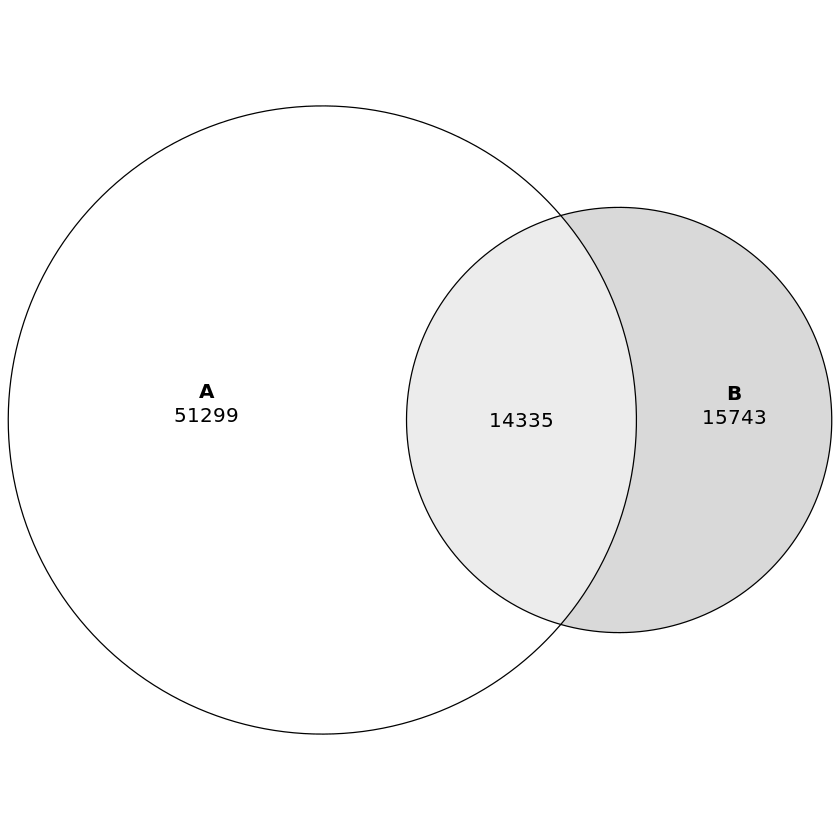

In [1]:
#make euler plot with values above. 
library(tidyverse)
library(eulerr)

#set names to variables
A_name <- "`Wang Active Bin`"
B_name <- "`Active Regions`"

#set values to variables:
A <- 65634
B <- 30078
A_B <- 14335

#make named list using variables above. This shouldn't change for all 3-way comparisons. 
combo <- c(A = A-A_B, B = B-A_B, 
           `A&B` = A_B)

eul <- plot(euler(combo), quantities = TRUE) 
eul

#save and edit in illustrator. 
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions'
ggsave(plot = eul, paste0(dir,"/euler-plot_AS-vs-hidra-bins.pdf"), width = 3, height = 3)

##### Discussion
This shows agreement with the section below. Only 14,335 of the active regions we identify are contained within the 65,000 active regions identified with their data. 

Lets see what happens when we use just the first two replicates.

### HiDRA in ATAC-STARR bins - 3 replicates

In [2]:
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(4))

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates_in-AS-bins.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length, -DNA4, -DNA5, -RNA4, -RNA5) %>% 
                        column_to_rownames(var = "Bin_ID") %>% filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA",
            "RNA","RNA","RNA")

RNames <- c("DNA1","DNA2","DNA3",
            "RNA1","RNA2","RNA3")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(4)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

write_tsv(res_df, paste0(dir, "/results/hiDRA_results_AS-bins_3-reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



In [3]:
filter_padj <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange > 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/results/hiDRA_active_3-reps", padj_val, ".bed"), 
              col_names = FALSE)
    return(active_bed)
}

active_1 <- filter_padj(res_df, cts_df, padj_val = 0.1)

In [1]:
%%bash

dir='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'

for val in 0.1
do
    bedtools merge -i ${dir}/results/hiDRA_active_3-reps${val}.bed | wc -l 
    bedtools merge -i ${dir}/results/hiDRA_active_3-reps${val}.bed > \
    ${dir}/results/hiDRA_active_3-reps${val}.merged-bins.bed  
done

39817


##### Discussion 
This suggests that more replicates would allow for more regions to be called active. With three reps we get ~40,000 active regions with hiDRA data but ~65,000 regions that are active when using 5 replicates. Lets look at the overlap now. 

In [2]:
%%bash
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'
AS="/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink"

bedtools jaccard -b ${dir}/results/hiDRA_active_3-reps0.1.merged-bins.bed \
-a ${AS}/active_regions.bed

wc -l ${AS}/active_regions.bed
wc -l ${dir}/results/hiDRA_active_3-reps0.1.merged-bins.bed

intersection	union	jaccard	n_intersections
1010646	8077747	0.125115	10479
30078 /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/active_regions.bed
39817 /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/results/hiDRA_active_3-reps0.1.merged-bins.bed


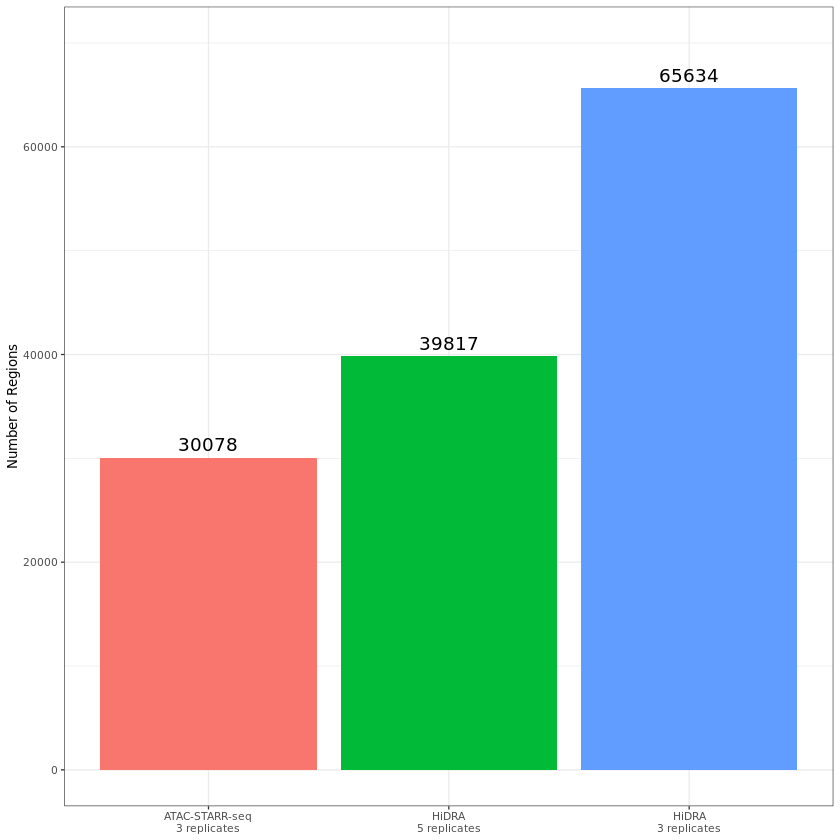

In [3]:
library(ggplot2)

df <- data.frame(Group = c("ATAC-STARR-seq\n3 replicates", "HiDRA\n5 replicates","HiDRA\n3 replicates"),
  value = c(30078,39817,65634))

df$Group <- factor(df$Group, levels = c("ATAC-STARR-seq\n3 replicates", "HiDRA\n5 replicates","HiDRA\n3 replicates"))

p <- ggplot(df, aes(x=Group, y=value, fill = Group)) +
  geom_col() +
  geom_text(aes(label = value), vjust = -0.5) +
  theme_bw(base_size = 8) + 
  ylab("Number of Regions") +
  theme(legend.position = "none", axis.title.x = element_blank()) +
  coord_cartesian(ylim = c(0, 70000))
p

res_dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures'
ggsave(p, filename = paste0(res_dir, "/hidra_reps_bar.pdf"), device = cairo_pdf, width = 3, height = 3)

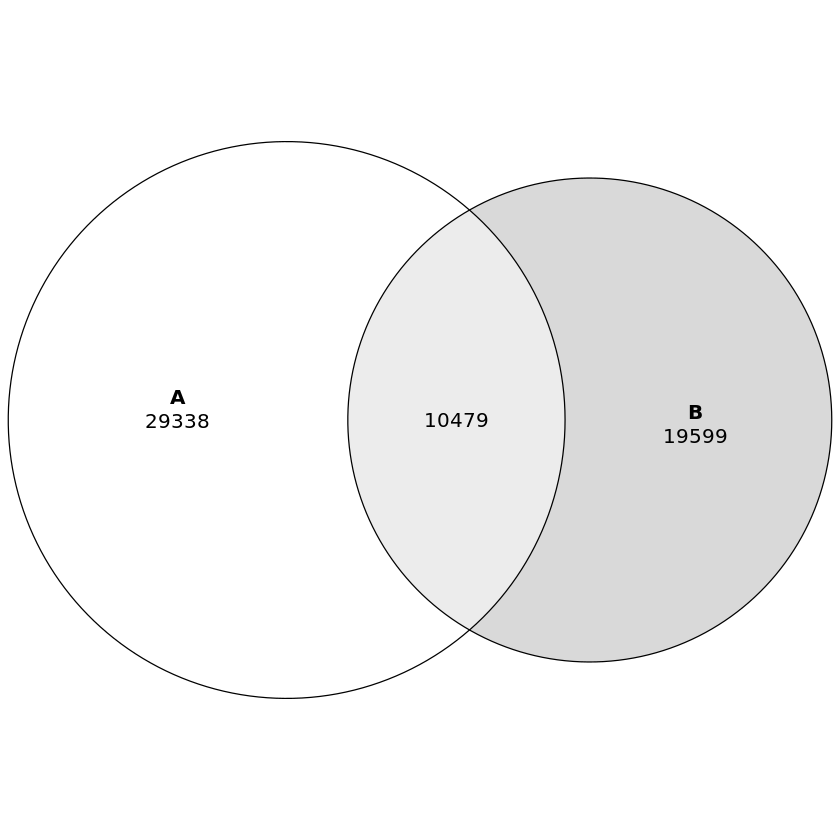

In [2]:
#make euler plot with values above. 
library(tidyverse)
library(eulerr)

#set names to variables
A_name <- "`Wang Active Bin`"
B_name <- "`Active Regions`"

#set values to variables:
A <- 39817
B <- 30078
A_B <- 10479

#make named list using variables above. This shouldn't change for all 3-way comparisons. 
combo <- c(A = A-A_B, B = B-A_B, 
           `A&B` = A_B)

eul <- plot(euler(combo), quantities = TRUE) 
eul

#save and edit in illustrator. 
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions'
ggsave(plot = eul, paste0(dir,"/euler-plot_AS-vs-hidra-bins_3reps.pdf"), width = 3, height = 3)

##### Discussion
While the number is similar, the overlap is not, only ~10,500 (1/3) regions are shared between the two datasets. Again this points to there being something inherently different with the datasets. 

### Summary of HiDRA vs ATAC-STARR 
Clearly the datsets are different somehow and it is likely this is at the reporter assay rather than library generation. I think the reason behind this could either be due to a promoter difference (ori vs mSCP1) or rather a difference in calculating DNA. We use reisolated sample and they use input. The systematic evaluation of.. paper showed good agreement in signal between the ori and scp1 promoters (0.83 pearson) so I think this may be at the level of plasmid DNA reisolation. 

To show this is a problem with their DNA do the following: 
1. Use their DNA (reps 1 and 2) with our RNA and see if the number and regions called are more in agreement with their regions or our regions. 
2. After, do this the opposite way (our DNA and their RNA) and check the same phenomenon. 

--the two above concepts did not work out. they actually resulted in MORE regions likely because the datasets are different. i only did this analysis for the two replicate ATAC-STARR samples. I never repeated with the third replicate. 

3. Afterwards, do this in another way using our DNA files. Merge replicates then subsample the merged version into three files. Show relatedness of the 3 psuedo-replicates with PCA and compare to the relatedness of their files. In theory their relatedness should be the same. Then call active regions using the psuedo-replicate DNA files and see if the result is more or less similar to what we identify with reisolated replicates. 

## Investigate differences in sequenced plasmid DNA

### HiDRA DNA, our RNA

In [5]:
HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'
AS='/data/hodges_lab/ATAC-STARR_V2'

featureCounts -p -O -B --minOverlap 1 -T 4 -F SAF -G /data/hodges_lab/hg38_genome/hg38.fa \
        -a ${AS}/data/activity/individual/bins/GM12878inGM12878_50bp-sliding-bins_10bp-step.saf  \
        -o ${HIDRA}/data/cts/Counts_hiDRA-DNA_AS-RNA.tsv \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_2.n-sorted.filtered.corrected.bam \
        ${AS}/data/bams/n-sorted/GM12878inGM12878_RNA_Rep1.filtered.n-sorted.bam \
        ${AS}/data/bams/n-sorted/GM12878inGM12878_RNA_Rep2.filtered.n-sorted.bam


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 4 BAM files                                      ||
||                           o HiDRA_DNA_Rep_1.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_2.n-sorted.filtered.correcte ... ||
||                           o GM12878inGM12878_RNA_Rep1.filtered.n-sorte ... ||
||                           o GM12878inGM12878_RNA_Rep2.filtered

In [ ]:
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(4))

dir <- '/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "data/cts/Counts_hiDRA-DNA_AS-RNA.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","RNA1","RNA2"), 
                   col_types = "cciiciiiii", skip = 2)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- as.matrix(dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length) %>% column_to_rownames(var = "Bin_ID"))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","RNA","RNA")

RNames <- c("DNA1","DNA2",
            "RNA1","RNA2")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

#Extract results: RNA/DNA
res <- lfcShrink(dds, coef="condition_RNA_vs_DNA", type="apeglm", parallel=TRUE, BPPARAM=MulticoreParam(4)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

write_tsv(res_df, paste0(dir, "/results/results_hidra-DNA_AS-RNA.bed"), col_names = FALSE)

#extract active regions using different padj filters
filter_padj <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange > 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/results/hidra-DNA_AS-RNA_active_", padj_val, "padj.bed"), 
              col_names = FALSE)
    return(active_bed)
}

active_1 <- filter_padj(res_df, cts_df, padj_val = 0.1)
active_05 <- filter_padj(res_df, cts_df, padj_val = 0.05)
active_01 <- filter_padj(res_df, cts_df, padj_val = 0.01)
active_005 <- filter_padj(res_df, cts_df, padj_val = 0.005)
active_001 <- filter_padj(res_df, cts_df, padj_val = 0.001)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [1]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

module restore tools
for val in 0.1 0.05 0.01 0.005 0.001
do
    bedtools merge -i ${dir}/results/hidra-DNA_AS-RNA_active_${val}padj.bed | wc -l 
    bedtools merge -i ${dir}/results/hidra-DNA_AS-RNA_active_${val}padj.bed > \
    ${dir}/results/hidra-DNA_AS-RNA_active_${val}padj.merged-bins.bed  
done

Restoring modules from user's tools
122942
119987
109743
104003
88098


In [2]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'
AS="/data/hodges_lab/ATAC-STARR_V2/data/activity/individual/DESeq2_results/bin-method"

module restore tools

bedtools jaccard -b ${dir}/results/hidra-DNA_AS-RNA_active_0.1padj.merged-bins.bed \
-a ${AS}/GM12878inGM12878_active_0.1padj_50-bin.merged.bed

bedtools jaccard -b ${dir}/results/hidra-DNA_AS-RNA_active_0.1padj.merged-bins.bed \
-a ${dir}/results/hiDRA_active_0.1padj_50-bin_5-reps_in-AS-bins.merged-bins.bed

wc -l ${AS}/GM12878inGM12878_active_0.1padj_50-bin.merged.bed
wc -l ${dir}/results/hiDRA_active_0.1padj_50-bin_5-reps_in-AS-bins.merged-bins.bed
wc -l ${dir}/results/hidra-DNA_AS-RNA_active_0.1padj.merged-bins.bed

Restoring modules from user's tools
intersection	union	jaccard	n_intersections
1415580	25394490	0.0557436	12538
intersection	union	jaccard	n_intersections
3935800	28406280	0.138554	44424
14617 /data/hodges_lab/ATAC-STARR_V2/data/activity/individual/DESeq2_results/bin-method/GM12878inGM12878_active_0.1padj_50-bin.merged.bed
51971 /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data//results/hiDRA_active_0.1padj_50-bin_5-reps_in-AS-bins.merged-bins.bed
122942 /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data//results/hidra-DNA_AS-RNA_active_0.1padj.merged-bins.bed


##### Discussion 
Wow! So with the hiDRA DNA and the AS RNA dataset, we get many many more regions called as active (122,942). Of the 14,600 we call as active, 12,538 are contained in this is region set. Of the 51,971 possible, we identify 44,424 of the same regions. This supports a model where non-transfected DNA used as a replicate is problematic. 

Next try the opposite, AS DNA with hiDRA RNA. 

### Our DNA, hiDRA RNA

In [1]:
HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'
AS='/data/hodges_lab/ATAC-STARR_V2'

featureCounts -p -O -B --minOverlap 1 -T 4 -F SAF -G /data/hodges_lab/hg38_genome/hg38.fa \
        -a ${AS}/data/activity/individual/bins/GM12878inGM12878_50bp-sliding-bins_10bp-step.saf  \
        -o ${HIDRA}/data/cts/Counts_AS-DNA_hiDRA-RNA.tsv \
        ${AS}/data/bams/n-sorted/GM12878inGM12878_DNA_Rep1.filtered.n-sorted.bam \
        ${AS}/data/bams/n-sorted/GM12878inGM12878_DNA_Rep2.filtered.n-sorted.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_1.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_2.n-sorted.filtered.corrected.bam 


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 4 BAM files                                      ||
||                           o GM12878inGM12878_DNA_Rep1.filtered.n-sorte ... ||
||                           o GM12878inGM12878_DNA_Rep2.filtered.n-sorte ... ||
||                           o HiDRA_RNA_Rep_1.n-sorted.filtered.correcte ... ||
||                           o HiDRA_RNA_Rep_2.n-sorted.filtered.

In [1]:
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(4))

dir <- '/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "data/cts/Counts_AS-DNA_hiDRA-RNA.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","RNA1","RNA2"), 
                   col_types = "cciiciiiii", skip = 2)

head(cts_df)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- as.matrix(dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length) %>% column_to_rownames(var = "Bin_ID"))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","RNA","RNA")

RNames <- c("DNA1","DNA2",
            "RNA1","RNA2")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

#Extract results: RNA/DNA
res <- lfcShrink(dds, coef="condition_RNA_vs_DNA", type="apeglm", parallel=TRUE, BPPARAM=MulticoreParam(4)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

write_tsv(res_df, paste0(dir, "/results/results_AS-DNA_hiDRA-RNA.bed"), col_names = FALSE)

#extract active regions using different padj filters
filter_padj <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange > 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/results/AS-DNA_hiDRA-RNA_active_", padj_val, "padj.bed"), 
              col_names = FALSE)
    return(active_bed)
}

active_1 <- filter_padj(res_df, cts_df, padj_val = 0.1)
active_05 <- filter_padj(res_df, cts_df, padj_val = 0.05)
active_01 <- filter_padj(res_df, cts_df, padj_val = 0.01)
active_005 <- filter_padj(res_df, cts_df, padj_val = 0.005)
active_001 <- filter_padj(res_df, cts_df, padj_val = 0.001)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

Bin_ID,Chr,Start,End,Strand,Length,DNA1,DNA2,RNA1,RNA2
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>
bin_1,chr1,778322,778372,.,51,11,11,15,6
bin_2,chr1,778332,778382,.,51,20,19,15,6
bin_3,chr1,778342,778392,.,51,26,25,20,16
bin_4,chr1,778352,778402,.,51,37,39,14,16
bin_5,chr1,778362,778412,.,51,47,48,25,38
bin_6,chr1,778372,778422,.,51,60,53,54,64


[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [1]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'

module restore tools
for val in 0.1 0.05 0.01 0.005 0.001
do
    bedtools merge -i ${dir}/results/AS-DNA_hiDRA-RNA_active_${val}padj.bed | wc -l 
    bedtools merge -i ${dir}/results/AS-DNA_hiDRA-RNA_active_${val}padj.bed > \
    ${dir}/results/AS-DNA_hiDRA-RNA_active_${val}padj.merged-bins.bed  
done

Restoring modules from user's tools
104182
99077
88881
85033
76782


##### Discussion
This is so confusing. With their RNA and our DNA we actually get MORE regions called as active than when we do 5 replicates with their sample. This could potentially be because the DNA and RNA are not from the same experiment. Testing the psuedoreplicates in the next step will be important for understanding this issue further. 

In [2]:
dir='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/'
AS="/data/hodges_lab/ATAC-STARR_V2/data/activity/individual/DESeq2_results/bin-method"

module restore tools

bedtools jaccard -b ${dir}/results/AS-DNA_hiDRA-RNA_active_0.1padj.merged-bins.bed \
-a ${AS}/GM12878inGM12878_active_0.1padj_50-bin.merged.bed

bedtools jaccard -b ${dir}/results/AS-DNA_hiDRA-RNA_active_0.1padj.merged-bins.bed \
-a ${dir}/results/hiDRA_active_0.1padj_50-bin_5-reps_in-AS-bins.merged-bins.bed

wc -l ${AS}/GM12878inGM12878_active_0.1padj_50-bin.merged.bed
wc -l ${dir}/results/hiDRA_active_0.1padj_50-bin_5-reps_in-AS-bins.merged-bins.bed
wc -l ${dir}/results/AS-DNA_hiDRA-RNA_active_0.1padj.merged-bins.bed

Restoring modules from user's tools
intersection	union	jaccard	n_intersections
831110	18136530	0.0458252	9595
intersection	union	jaccard	n_intersections
4190800	20308850	0.206353	36713
14617 /data/hodges_lab/ATAC-STARR_V2/data/activity/individual/DESeq2_results/bin-method/GM12878inGM12878_active_0.1padj_50-bin.merged.bed
51971 /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data//results/hiDRA_active_0.1padj_50-bin_5-reps_in-AS-bins.merged-bins.bed
104182 /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data//results/AS-DNA_hiDRA-RNA_active_0.1padj.merged-bins.bed


##### Discussion
The overlap is less than the opposite comparison, but it is hard to interpet that.  

### __Call active regions in ATAC-STARR with psuedo-replicates.__

If their DNA files are too closely related, then we can simulate this in our data by making merged and split psuedo-replicates. If making our DNA files more closely related causes a dramatic increase in the number of regions called as active, then high-similarity DNA replicates pose a problem. 

#### split merged filtered DNA bam into three psuedo-replicates

In [4]:
%%bash
#using merged bams, subsample each into 5 pseduo replicates. 
#Change the seed value for every subsample and extract 20% of reads. -s [INT.frac]. INT is seed.
# Samtools documentation: 
#   -s FLOAT subsample reads (given INT.FRAC option value, 0.FRAC is the
#   fraction of templates/read pairs to keep; INT part sets seed)

AS='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams'

for rep in 1 2 3 
do
    #DNA
    samtools view -@ 4 -s ${rep}.2 -b ${AS}/merged_replicates/GM12878inGM12878_DNA_merged.filtered.n-sorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_DNA_${rep}.filtered.unsorted.bam
    #n-sort
    samtools sort -@ 4 -n ${AS}/pseudo_replicates/GM12878inGM12878_DNA_${rep}.filtered.unsorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_DNA_${rep}.filtered.n-sorted.bam
done

[bam_sort_core] merging from 8 files and 4 in-memory blocks...
[bam_sort_core] merging from 8 files and 4 in-memory blocks...
[bam_sort_core] merging from 8 files and 4 in-memory blocks...


In [9]:
%%bash
#With the pseduoreplicates, make a new cts matrix. 
AS='/data/hodges_lab/ATAC-STARR_B-cells'
OUT='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

featureCounts -p -O -B --minOverlap 1 -T 4 -F SAF -G /data/hodges_lab/hg38_genome/hg38.fa \
        -a ${AS}/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/bins.saf  \
        -o ${OUT}/Counts_psuedo-DNA_AS.tsv \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_1.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_2.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_3.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/individual_replicates/GM12878inGM12878_RNA_Rep1.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/individual_replicates/GM12878inGM12878_RNA_Rep2.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/individual_replicates/GM12878inGM12878_RNA_Rep3.filtered.n-sorted.bam


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 6 BAM files                                      ||
||                           o GM12878inGM12878_DNA_1.filtered.n-sorted.bam   ||
||                           o GM12878inGM12878_DNA_2.filtered.n-sorted.bam   ||
||                           o GM12878inGM12878_DNA_3.filtered.n-sorted.bam   ||
||                           o GM12878inGM12878_RNA_Rep1.filtered

In [4]:
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(4))

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "/Counts_psuedo-DNA_AS.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","RNA1","RNA2","RNA3"), 
                   col_types = "cciiciiiiiii", skip = 2)

head(cts_df)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- as.matrix(dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length) %>% column_to_rownames(var = "Bin_ID"))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA",
            "RNA","RNA","RNA")

RNames <- c("DNA1","DNA2","DNA3",
            "RNA1","RNA2","RNA3")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(4)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

Bin_ID,Chr,Start,End,Strand,Length,DNA1,DNA2,DNA3,RNA1,RNA2,RNA3
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
bin_1,chr1,267896,267945,.,50,3,3,3,1,35,1
bin_2,chr1,267906,267955,.,50,3,3,3,1,35,6
bin_3,chr1,267916,267965,.,50,5,5,6,19,40,6
bin_4,chr1,267926,267975,.,50,7,7,6,30,43,7
bin_5,chr1,267936,267985,.,50,9,8,7,34,54,11
bin_6,chr1,267946,267995,.,50,10,8,7,34,54,22


[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



In [5]:
#extract active regions using different padj filters
filter_padj <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange > 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/psuedo-DNA_AS_active_", padj_val, "padj.bed"), 
              col_names = FALSE)
    return(active_bed)
}

active_1 <- filter_padj(res_df, cts_df, padj_val = 0.1)

In [2]:
%%bash
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

for val in 0.1 
do
    bedtools merge -i ${dir}/psuedo-DNA_AS_active_${val}padj.bed | wc -l 
    bedtools merge -i ${dir}/psuedo-DNA_AS_active_${val}padj.bed > \
    ${dir}/psuedo-DNA_AS_active_${val}padj.merged-bins.bed  
done

20119


Restoring modules from user's tools


In [4]:
%%bash
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'
AS="/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink"

bedtools jaccard -b ${dir}/psuedo-DNA_AS_active_0.1padj.merged-bins.bed  \
-a ${AS}/active_regions.bed

wc -l ${AS}/active_regions.bed

intersection	union	jaccard	n_intersections
1947406	4374925	0.445129	16555
30078 /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/active_regions.bed


##### Discussion
The the there is actually a decrease in the number of regions called active and these do not overlap well. 

### Summary of Plasmid DNA differences in sequencing

Overall, it looks like the hypothesis that similarity of plasmid DNA files does not contribute significantly to the regions we identify as active. Using pseudo-replicates, we improve region number by ~5,000 but not by the amount that we see for hiDRA. This number seems to be influenced primarily by replicate number. 

What is odd is that when you mix hidra DNA and AS RNA and vice-versa, we get a huge increase in the number of active regions called. This is likely because the two DNA sets are different from each other and since the DESeq2 test is based on differential counts increasingly different DNA will cause more regions to be called active.

Importantly, we see very little overlap in the regions called as active when comparing hiDRA and ATAC-STARR at any level. Together with the point above about incompatibilities driving more active regions, this suggests that the differnce between the two experiments lies with the plasmid libraries that were generated. Therefore, I think the next step is to look at differences in the two DNA libraries.  

## Investigate differences in the makeup of the DNA plasmid libraries

There could be differences in the composition of the DNA library that are driving the differences we see. Some obvious differences:
1. Lower complexity (9.7e6 unique plasmids for HiDRA and 50e6 for ATAC-STARR). 
2. Size selection difference on lower end (hiDRA selects 150-500, we select < 500). 

Before getting into this, investigate the regions that are not the same between hiDRA and ATAC-STARR.  

### Identify and characterize the active regions that are different between hiDRA and AS

In [5]:
%%bash
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/'
AS="/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink"

module restore tools

#extract regions that are shared
bedtools intersect -a ${dir}/results/hiDRA_active_0.1padj_50-bin_5-reps_in-AS-bins.merged-bins.bed  \
-b ${AS}/active_regions.bed > ${dir}/results/shared.bed

#extract regions that are specific to hiDRA
bedtools intersect -v -a ${dir}/results/hiDRA_active_0.1padj_50-bin_5-reps_in-AS-bins.merged-bins.bed  \
-b ${AS}/active_regions.bed > ${dir}/results/hidra-specific.bed

#extract regions that are specific to AS
bedtools intersect -v -b ${dir}/results/hiDRA_active_0.1padj_50-bin_5-reps_in-AS-bins.merged-bins.bed  \
-a ${AS}/active_regions.bed > ${dir}/results/AS-specific.bed

#how many for each file?
wc -l ${dir}/results/shared.bed
wc -l ${dir}/results/hidra-specific.bed
wc -l ${dir}/results/AS-specific.bed

13184 /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data//results/shared.bed
40030 /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data//results/hidra-specific.bed
19177 /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data//results/AS-specific.bed


Restoring modules from user's tools


In [3]:
#annotate by distance to TSS
library(tidyverse)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'

shared <- annotatePeak(paste0(dir, "/results/shared.bed"),tssRegion = c(-2000, 1000), 
                       TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene)

AS <- annotatePeak(paste0(dir, "/results/AS-specific.bed"),tssRegion = c(-2000, 1000), 
                       TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene)

hidra <- annotatePeak(paste0(dir, "/results/hidra-specific.bed"),tssRegion = c(-2000, 1000), 
                       TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene)

>> loading peak file...				 2021-11-10 01:29:50 PM 
>> preparing features information...		 2021-11-10 01:29:50 PM 
>> identifying nearest features...		 2021-11-10 01:29:55 PM 
>> calculating distance from peak to TSS...	 2021-11-10 01:29:56 PM 
>> assigning genomic annotation...		 2021-11-10 01:29:56 PM 
>> assigning chromosome lengths			 2021-11-10 01:30:41 PM 
>> done...					 2021-11-10 01:30:41 PM 
>> loading peak file...				 2021-11-10 01:30:41 PM 
>> preparing features information...		 2021-11-10 01:30:42 PM 
>> identifying nearest features...		 2021-11-10 01:30:42 PM 
>> calculating distance from peak to TSS...	 2021-11-10 01:30:42 PM 
>> assigning genomic annotation...		 2021-11-10 01:30:42 PM 
>> assigning chromosome lengths			 2021-11-10 01:30:47 PM 
>> done...					 2021-11-10 01:30:47 PM 
>> loading peak file...				 2021-11-10 01:30:47 PM 
>> preparing features information...		 2021-11-10 01:30:47 PM 
>> identifying nearest features...		 2021-11-10 01:30:47 PM 
>> calculating

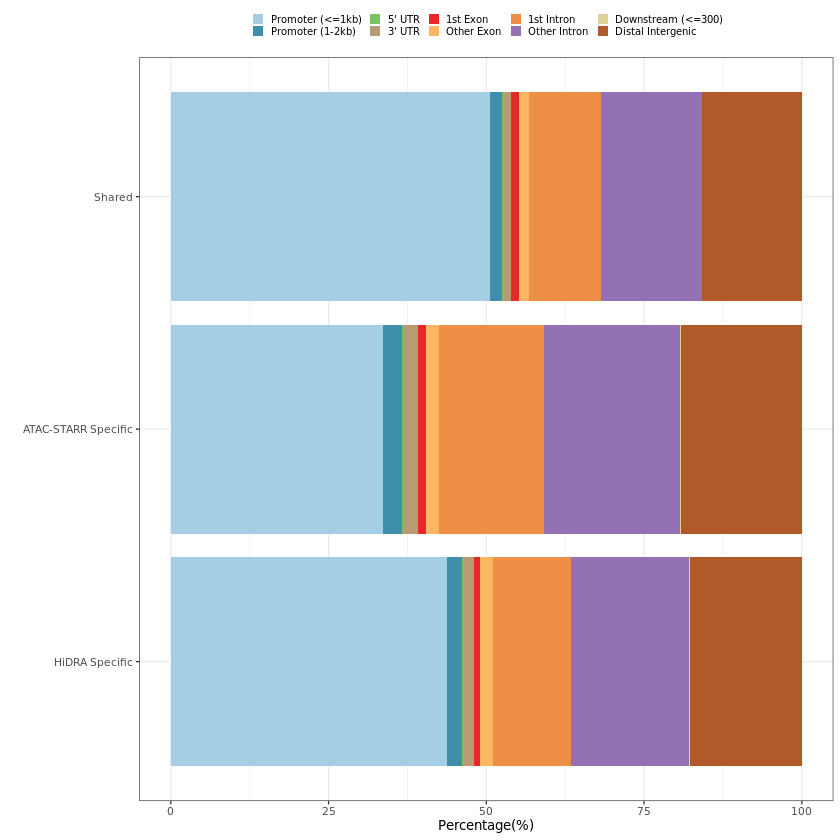

In [4]:
bar <- plotAnnoBar(list(`Shared`=shared, `ATAC-STARR Specific`=AS, `HiDRA Specific`=hidra)) + 
    theme_bw(base_size = 8) + 
    theme(legend.key.size = unit(0.1, "in"),legend.title = element_blank(), plot.title = element_blank(), 
          legend.position = "top", legend.text = element_text(size = 6)) 
bar

ggsave(paste0(dir, "/results/annotation-barchart.pdf"), plot = bar, device = cairo_pdf, width = 4, height = 2)

##### Discussion
Hmm, this is not what I expected. This shows that shared regions are more promoter heavy than the AS-specific. My hypothesis of hiDRA missing the NFR and possibly promoters would have expected the opposite observation. Therefore the regions that are missing tend to be enhancers more than promoters. 

clusterProfiler v4.0.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


ReactomePA v1.36.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/reactomepa.html

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis 

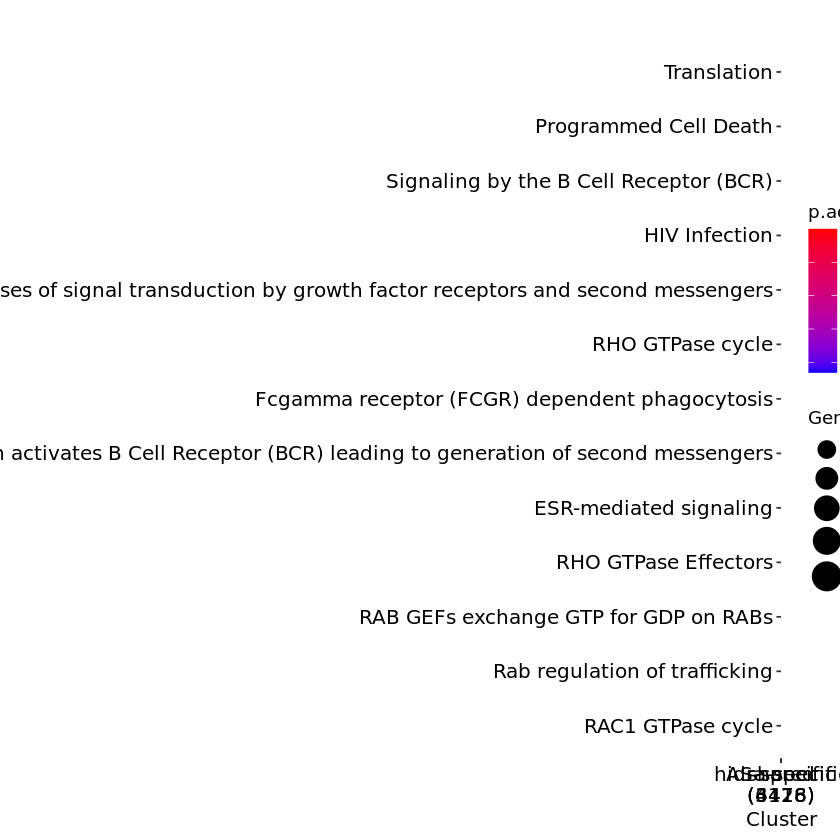

In [5]:
library(clusterProfiler)
library(ReactomePA)

#Try pathway enrichment...
gene_list <- list(shared = as.data.frame(shared)$geneId, 
                  `AS-specific` = as.data.frame(AS)$geneId,
                  `hidra-specific` = as.data.frame(hidra)$geneId)

p <- dotplot(compareCluster(gene_list, fun = "enrichPathway", pvalueCutoff = 0.2)) + theme_bw(base_size = 8)

ggsave(paste0(dir, "/results/reactome-pathway.pdf"), plot = p, device = cairo_pdf, width = 8, height = 4)

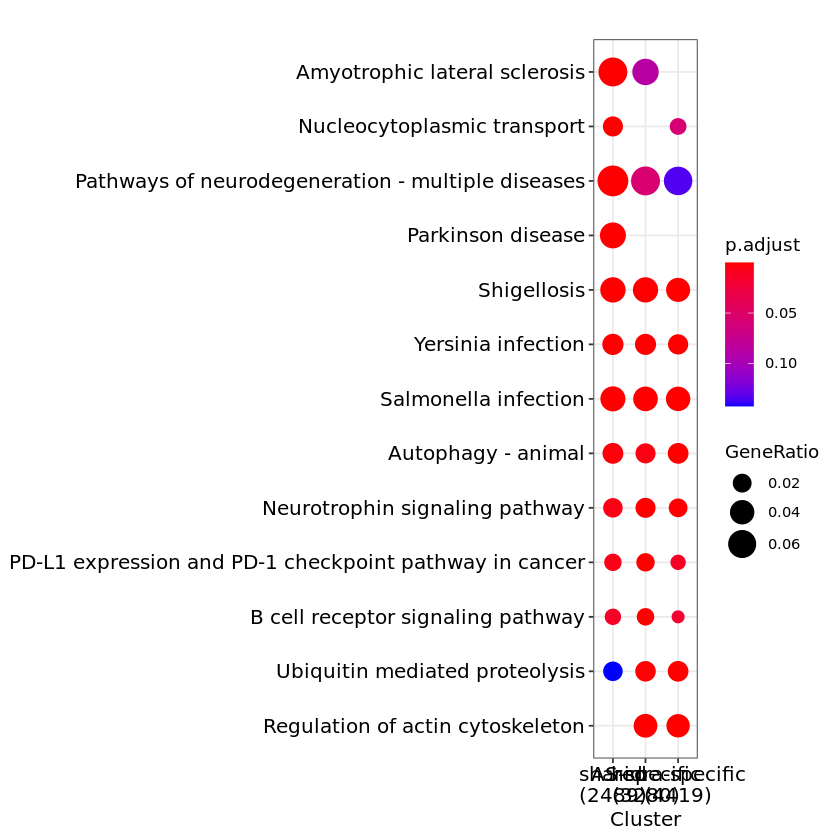

In [6]:
#Try pathway enrichment...
gene_list <- list(shared = as.data.frame(shared)$geneId, 
                  `AS-specific` = as.data.frame(AS)$geneId,
                  `hidra-specific` = as.data.frame(hidra)$geneId)

p2 <- dotplot(compareCluster(gene_list, fun = "enrichKEGG", pvalueCutoff = 0.2)) + theme_bw(base_size = 8)

ggsave(paste0(dir, "/results/KEGG-pathway.pdf"), plot = p2, device = cairo_pdf, width = 8, height = 4)

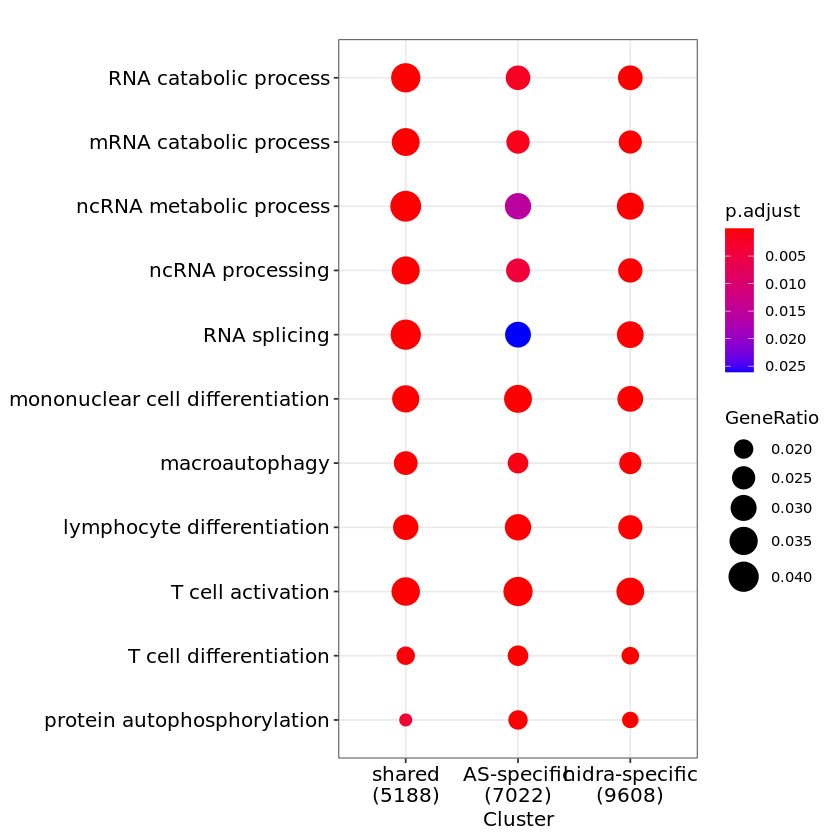

In [7]:
library(org.Hs.eg.db)

#Try pathway enrichment...
gene_list <- list(shared = as.data.frame(shared)$geneId, 
                  `AS-specific` = as.data.frame(AS)$geneId,
                  `hidra-specific` = as.data.frame(hidra)$geneId)

p3 <- dotplot(compareCluster(gene_list, fun = "enrichGO", ont = "BP", OrgDb = org.Hs.eg.db, pvalueCutoff = 0.2)) + 
    theme_bw(base_size = 8)

ggsave(paste0(dir, "/results/GO-BP-pathway.pdf"), plot = p3, device = cairo_pdf, width = 8, height = 4)

##### Discussion
It is inconclusive as to how these regions are different from each other. They regulate the same pathways.

### Compare ChrAcc peaks
Rather than comparing the active regions, lets now focus on the DNA inserts. We called 900,00+ chrAcc regions for hiDRA. This is likely due to more replicates. To be working on the same page, re-call peaks only using replicates 1, 2, and 3 for hiDRA and compare to the ATAC-STARR peaks. 

In [2]:
%%bash
HIDRA='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'

/home/hansetj1/Genrich/Genrich -t ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.unique.corrected.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_2.n-sorted.unique.corrected.bam,${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_3.n-sorted.unique.corrected.bam \
    -o ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_3-reps.narrowPeak -j -v

#filter result for 0.0001 qvalue. Use awk to filter the ninth column, which corresponds to the -log10(qvalue).
awk 'BEGIN{OFS=FS="\t"}{if ($9>4) print}' ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_3-reps.narrowPeak > \
${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_3-reps_0.0001-qvalue.narrowPeak

#print count of regions:
wc -l ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_3-reps_0.0001-qvalue.narrowPeak

181722 /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/data/chrAcc-peaks/HiDRA_DNA_genrich_3-reps_0.0001-qvalue.narrowPeak


Processing experimental file #0: /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.unique.corrected.bam
  BAM records analyzed:  148347222
    Paired alignments:   148347222
      "orphan" alns:         11874
    Unpaired alignments:         0
  Fragments analyzed:     74167674
    Full fragments:       74167674
    ATAC-seq cut sites:  148335348
      (expanded to length 100bp)
- control file #0 not provided -
  Background pileup value: 4.621943
Processing experimental file #1: /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/data/bams/n-sorted/HiDRA_DNA_Rep_2.n-sorted.unique.corrected.bam
  BAM records analyzed:  109699201
    Paired alignments:   109699201
      "orphan" alns:          8487
    Unpaired alignments:         0
  Fragments analyzed:     54845357
    Full fragments:       54845357
    ATAC-seq cut sites:  109690714
      (expanded to length 100bp)
- control file 

In [2]:
%%bash
HIDRA='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'

#now compare overlap:
bedtools jaccard -a /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/ChrAcc_peaks/GM12878inGM12878_DNA_genrich_3-replicates_0.0001-qvalue.narrowPeak \
-b ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_3-reps_0.0001-qvalue.narrowPeak

wc -l ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_3-reps_0.0001-qvalue.narrowPeak
wc -l /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/ChrAcc_peaks/GM12878inGM12878_DNA_genrich_3-replicates_0.0001-qvalue.narrowPeak

intersection	union	jaccard	n_intersections
33822002	121143467	0.27919	65746
181722 /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/data/chrAcc-peaks/HiDRA_DNA_genrich_3-reps_0.0001-qvalue.narrowPeak
101904 /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/ChrAcc_peaks/GM12878inGM12878_DNA_genrich_3-replicates_0.0001-qvalue.narrowPeak


ERROR: Database file /data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/data/chrAcc-peaks/HiDRA_DNA_genrich_3-reps_0.0001-qvalue.narrowPeak contains chromosome chrY, but the query file does not.
       Please rerun with the -g option for a genome file.
       See documentation for details.


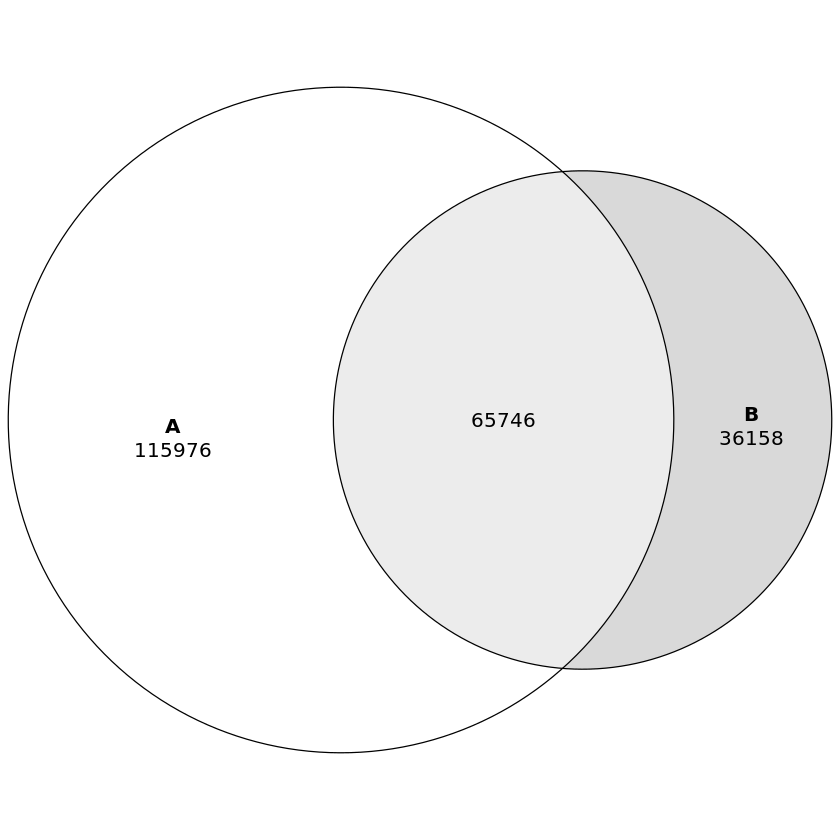

In [2]:
#make euler plot with values above. 
library(tidyverse)
library(eulerr)

#set names to variables
A_name <- "`Wang ChrAcc`"
B_name <- "`AS ChrAcc`"

#set values to variables:
A_B <- 65746
A <- 181722
B <- 101904

#make named list using variables above. This shouldn't change for all 3-way comparisons. 
combo <- c(A = A-A_B, B = B-A_B, 
           `A&B` = A_B)

eul <- plot(euler(combo), quantities = TRUE) 
eul

#save and edit in illustrator. 
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions'
ggsave(plot = eul, paste0(dir,"/euler-plot_AS-vs-hidra-ChrAcc.pdf"), width = 3, height = 3)

##### Discussion
Of the maximum nubmer of potential overlaps (101,904) we see only 45,918 regions are shared between the two. This is ~45%, which means about 55% of ChrAcc peaks differ between the two datasets. This could drive the differences we see.  

To see if the hiDRA is more like buenrostro than ATAC-STARR is, compare hiDRA to buen. 

In [9]:
%%bash
HIDRA='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'
BUEN='/data/hodges_lab/public_data/GM12878/obtained_as_raw_files/ATAC_GM12878_2013-buenrostro/data/genrich_peaks/GM12878_ATAC-seq_buenrostro_genrich_0.0001-qvalue.narrowPeak'
AS='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/ChrAcc_peaks/GM12878inGM12878_DNA_genrich_3-replicates_0.0001-qvalue.narrowPeak'
#now compare overlap:
bedtools jaccard -a $BUEN \
-b ${HIDRA}/data/chrAcc-peaks/HiDRA_DNA_genrich_2-reps_0.0005-qvalue.narrowPeak

wc -l $BUEN

bedtools jaccard -a $AS \
-b $BUEN

wc -l $AS

intersection	union	jaccard	n_intersections
26447656	66115346	0.400023	47611
82337 /data/hodges_lab/public_data/GM12878/obtained_as_raw_files/ATAC_GM12878_2013-buenrostro/data/genrich_peaks/GM12878_ATAC-seq_buenrostro_genrich_0.0001-qvalue.narrowPeak
intersection	union	jaccard	n_intersections
38454012	80486872	0.477767	62443
101904 /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/ChrAcc_peaks/GM12878inGM12878_DNA_genrich_3-replicates_0.0001-qvalue.narrowPeak


##### Discussion 
The jaccard index is better for ours. Still, the hiDRA jaccard is 0.4, suggesting close to similar overlap. 

## Summary of hiDRA and ATAC-STARR active region differences

We see that the regions called as ChrAcc in both contexts have only 60% overlap suggesting this is the likely source of deviation between the two samples. This is further evidenced by the PCA plot in section 3.3.3. 

In terms of who has a more accurate peak set, our modest improvement in jaccard and overlap with buenrostro peakset suggests ATAC-STARR is more accurate, but not drastically better. 

I think the conclusion here is that the inserts in hiDRA and ATAC-STARR do not match each other as well as we would expect. The most likely reason for this is the exclusion of fragments less than 150bp for hiDRA. Their library is bigger and likely reflects regions of larger NFRs or larger nucleosome-devoid regions. ATAC-STARR probably contains better coverage for smaller NFRs. We could do additional analysis but it is likely that our current results aer sufficent for explaining the differences we see. 

# Effect of biological replicate count on region count

To figure out how increasing number of replicates influences region count, I will make 5 pseudo-replicates from my data. And compare active and silent region counts when adding replicates. I'll compare 2,3,4,5 replicates. 

In [ ]:
%%bash
#using merged bams, subsample each into 5 pseduo replicates. 
#Change the seed value for every subsample and extract 20% of reads. -s [INT.frac]. INT is seed.
# Samtools documentation: 
#   -s FLOAT subsample reads (given INT.FRAC option value, 0.FRAC is the
#   fraction of templates/read pairs to keep; INT part sets seed)

AS='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/merged_replicates'

for rep in 4 5 #already did 1-3
do
    #DNA
    samtools view -@ 4 -s ${rep}.2 -b ${AS}/merged_replicates/GM12878inGM12878_DNA_merged.filtered.n-sorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_DNA_${rep}.filtered.unsorted.bam
    #n-sort
    samtools sort -@ 4 -n ${AS}/pseudo_replicates/GM12878inGM12878_DNA_${rep}.filtered.unsorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_DNA_${rep}.filtered.n-sorted.bam
done

In [12]:
%%bash

AS='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams'

for rep in 1 2 3 4 5
do
    #RNA
    samtools view -@ 4 -s ${rep}.2 -b ${AS}/merged_replicates/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_RNA_${rep}.filtered.unsorted.bam
    #n-sort
    samtools sort -@ 4 -n ${AS}/pseudo_replicates/GM12878inGM12878_RNA_${rep}.filtered.unsorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_RNA_${rep}.filtered.n-sorted.bam
done

[bam_sort_core] merging from 28 files and 4 in-memory blocks...
[bam_sort_core] merging from 28 files and 4 in-memory blocks...
[bam_sort_core] merging from 28 files and 4 in-memory blocks...
[bam_sort_core] merging from 28 files and 4 in-memory blocks...
[bam_sort_core] merging from 28 files and 4 in-memory blocks...


In [1]:
%%bash
#run feature counts with all 5 pseduo replicates.

OUT='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'
AS='/data/hodges_lab/ATAC-STARR_B-cells'

featureCounts -p -O -B --minOverlap 1 -T 8 -F SAF -G /data/hodges_lab/hg38_genome/hg38.fa \
        -a ${AS}/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/bins.saf \
        -o ${OUT}/counts_psuedo-replicates_all.tsv \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_1.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_2.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_3.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_4.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_5.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_1.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_2.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_3.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_4.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_5.filtered.n-sorted.bam 


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 10 BAM files                                     ||
||                           o GM12878inGM12878_DNA_1.filtered.n-sorted.bam   ||
||                           o GM12878inGM12878_DNA_2.filtered.n-sorted.bam   ||
||                           o GM12878inGM12878_DNA_3.filtered.n-sorted.bam   ||
||                           o GM12878inGM12878_DNA_4.filtered.n-

In [2]:
#Load required libraries
library(DESeq2)
library(tidyverse)
library(BiocParallel)
register(MulticoreParam(4))

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "/counts_psuedo-replicates_all.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

#Clean df. Make Bin_ID the rownames.
cts_clean <- dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length) %>% 
        column_to_rownames(var = "Bin_ID")

#create 4 different matricies that each represent a differnt nubmer of replicates. 
cts_2 <- dplyr::select(cts_clean, DNA1, DNA2, RNA1, RNA2) %>% 
        filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()
        
cts_3 <- dplyr::select(cts_clean, DNA1, DNA2, DNA3, RNA1, RNA2, RNA3) %>% 
        filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()
        
cts_4 <- dplyr::select(cts_clean, DNA1, DNA2, DNA3, DNA4, RNA1, RNA2, RNA3, RNA4) %>% 
        filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()
        
cts_5 <- cts_clean %>% filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()

## Two pseudo replicates

In [4]:
register(MulticoreParam(4))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","RNA","RNA")
RNames <- c("DNA1","DNA2",
            "RNA1","RNA2")
coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_2))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_2, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(4)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#extract active regions using different padj filters
active_2 <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange > 0) 

active_bed_2 <- left_join(active_2, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
    dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% dplyr::arrange(Chr, Start, End)

write_tsv(active_bed_2, paste0(dir, "/psuedo-reps_active-2reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



## Three pseudo replicates

In [5]:
register(MulticoreParam(8))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA",
               "RNA","RNA","RNA")
               
RNames <- c("DNA1","DNA2","DNA3",
            "RNA1","RNA2","RNA3")
            
coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_3))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_3, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(8))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(8)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#extract active regions using different padj filters
active_3 <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange > 0) 

active_bed_3 <- left_join(active_3, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
    dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% dplyr::arrange(Chr, Start, End)

write_tsv(active_bed_3, paste0(dir, "/psuedo-reps_active-3reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 8 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 8 workers



## Four pseudo replicates

In [6]:
register(MulticoreParam(8))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA","DNA",
               "RNA","RNA","RNA","RNA")
               
RNames <- c("DNA1","DNA2","DNA3","DNA4",
            "RNA1","RNA2","RNA3","RNA4")
            
coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_4))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_4, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(8))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(8)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#extract active regions using different padj filters
active_4 <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange > 0) 

active_bed_4 <- left_join(active_4, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
    dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% dplyr::arrange(Chr, Start, End)

write_tsv(active_bed_4, paste0(dir, "/psuedo-reps_active-4reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 8 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 8 workers



## Five pseudo replicates

In [7]:
register(MulticoreParam(8))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA","DNA","DNA",
               "RNA","RNA","RNA","RNA","RNA")
               
RNames <- c("DNA1","DNA2","DNA3","DNA4","DNA5",
            "RNA1","RNA2","RNA3","RNA4","RNA5")
            
coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_5))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_5, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(8))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(4)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#extract active regions using different padj filters
active_5 <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange > 0) 

active_bed_5 <- left_join(active_5, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
    dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% dplyr::arrange(Chr, Start, End)

write_tsv(active_bed_5, paste0(dir, "/psuedo-reps_active-5reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 8 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 8 workers



## Comparison

In [1]:
%%bash
#merge to determine number of regions for each replicate count
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

for rep_num in 2 3 4 5 
do
    bedtools merge -i ${dir}/psuedo-reps_active-${rep_num}reps.bed | wc -l 
    bedtools merge -i ${dir}/psuedo-reps_active-${rep_num}reps.bed > \
    ${dir}/psuedo-reps_active-${rep_num}reps.merged-bins.bed  
done

26966
74410
102041
117674


Restoring modules from user's tools


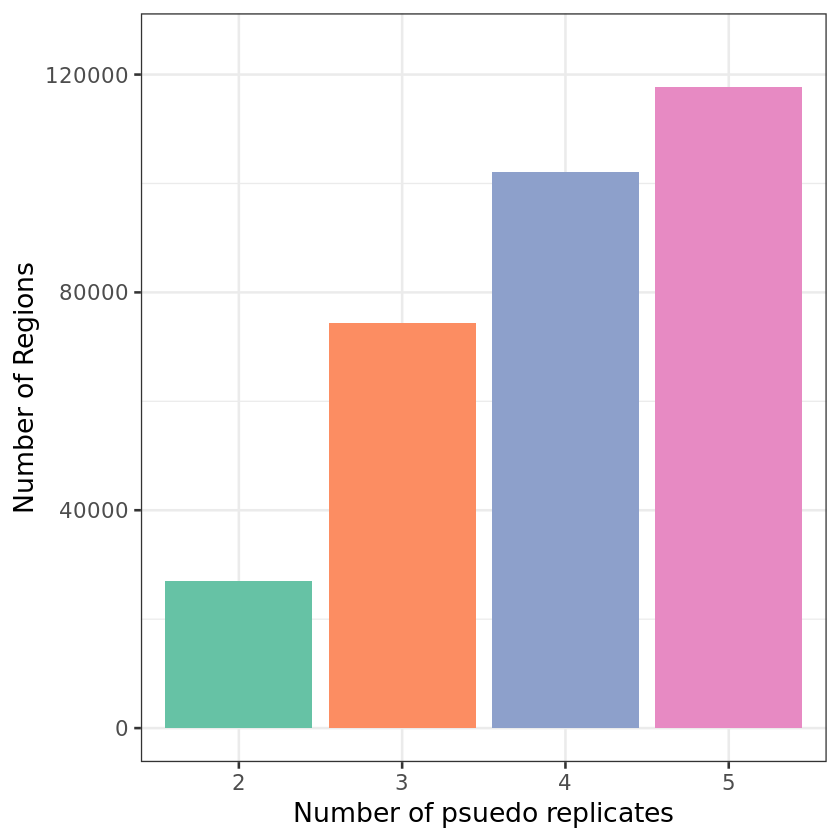

In [7]:
#Make bar plot of active region counts vs replicate number
df <- data.frame(rep_number = c(2,3,4,5), 
                 count = c(26966,74410,102041,117674))
df$rep_number <- as.factor(df$rep_number)
library(ggplot2)
library(ggsci)

p <- ggplot(df, aes(x=rep_number, y=count)) +
    geom_col(aes(fill=rep_number)) +
    theme_bw(base_family = "Arial", base_size = 16) + 
    ylab("Number of Regions") +
    xlab("Number of psuedo replicates") +
    scale_fill_brewer(palette = "Set2") +
    theme(legend.position = "none") +
    coord_cartesian(ylim = c(0,125000))


p

ggsave("/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps/bar_plot.pdf", plot = p, 
      device = cairo_pdf, width = 4, height = 3)

In [2]:
%%bash
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'
AS="/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink"


bedtools jaccard -b ${dir}/psuedo-reps_active-2reps.merged-bins.bed \
-a ${AS}/active_regions.bed

bedtools jaccard -b ${dir}/psuedo-reps_active-2reps.merged-bins.bed \
-a ${dir}/psuedo-reps_active-5reps.merged-bins.bed

bedtools jaccard -b ${dir}/psuedo-reps_active-5reps.merged-bins.bed \
-a ${AS}/active_regions.bed

bedtools jaccard -b ${dir}/psuedo-reps_active-3reps.merged-bins.bed \
-a ${AS}/active_regions.bed

intersection	union	jaccard	n_intersections
2063145	5077019	0.406369	17941
intersection	union	jaccard	n_intersections
3161993	17167177	0.184188	26977
intersection	union	jaccard	n_intersections
3888156	17216170	0.225843	30143
intersection	union	jaccard	n_intersections
3543441	10109299	0.350513	28461


In [2]:
%%bash
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'
wc -l ${dir}/psuedo-reps_active-5reps.merged-bins.bed
wc -l ${dir}/psuedo-reps_active-2reps.merged-bins.bed

bedtools jaccard -b ${dir}/psuedo-reps_active-2reps.merged-bins.bed \
-a ${dir}/psuedo-reps_active-5reps.merged-bins.bed

117674 /data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps/psuedo-reps_active-5reps.merged-bins.bed
26966 /data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps/psuedo-reps_active-2reps.merged-bins.bed
intersection	union	jaccard	n_intersections
3161993	17167177	0.184188	26977


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



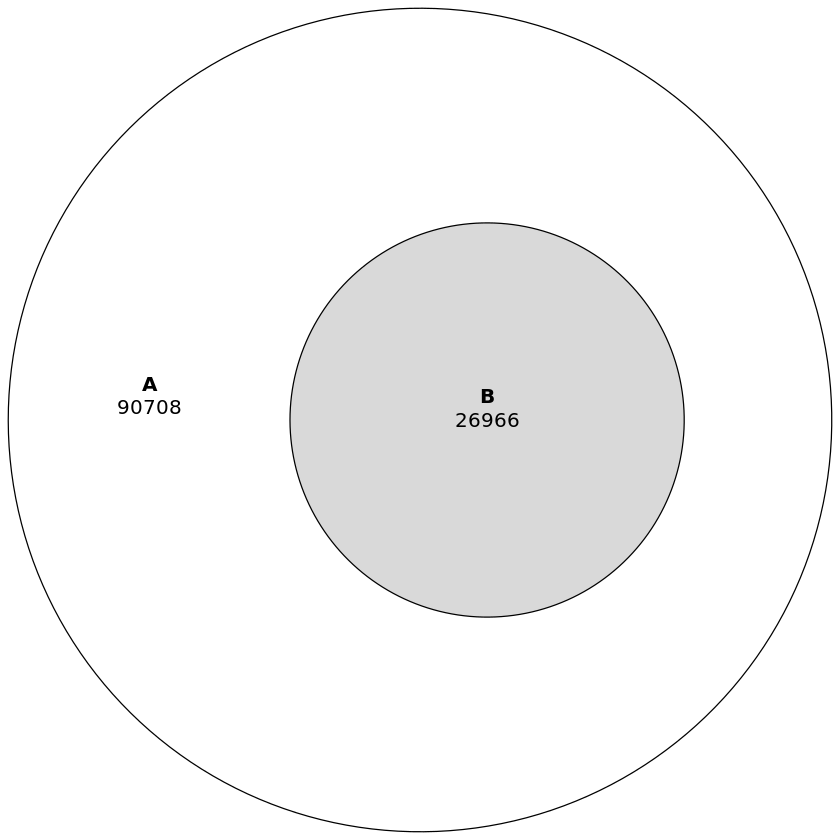

In [1]:
#make euler plot with values above. 
library(tidyverse)
library(eulerr)

#set names to variables
A_name <- "`5 Replicates`"
B_name <- "`2 Replicates`"

#set values to variables:
A <- 117674
B <- 26966
A_B <- 26966

#make named list using variables above. This shouldn't change for all 3-way comparisons. 
combo <- c(A = A-A_B, B = B-A_B, 
           `A&B` = A_B)

eul <- plot(euler(combo), quantities = TRUE) 
eul

#save and edit in illustrator. 
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps/'
ggsave(plot = eul, paste0(dir,"/euler-plot_5-2_pseudo-reps.pdf"), width = 3, height = 3)

### ChromHMM differences

In [1]:
%%bash

#BedFiles
CHMM_DIR='/data/hodges_lab/public_data/GM12878/obtained_as_processed_files'
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

for i in 2 3 4 5
do
    bedtools intersect -u -a ${CHMM_DIR}/GM12878_ChromHMM_18-state_E116_18_core_K27ac_hg38lift_mnemonics.bed \
        -b ${dir}/psuedo-reps_active-${i}reps.merged-bins.bed > ${dir}/psuedo_${i}-reps_ChromHMM.bed
done


── Column specification ────────────────────────────────────────────────────────
cols(
  Chr = col_character(),
  Start = col_double(),
  End = col_double(),
  Chrom_HMM_State = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  Chr = col_character(),
  Start = col_double(),
  End = col_double(),
  Chrom_HMM_State = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  Chr = col_character(),
  Start = col_double(),
  End = col_double(),
  Chrom_HMM_State = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  Chr = col_character(),
  Start = col_double(),
  End = col_double(),
  Chrom_HMM_State = col_character()
)




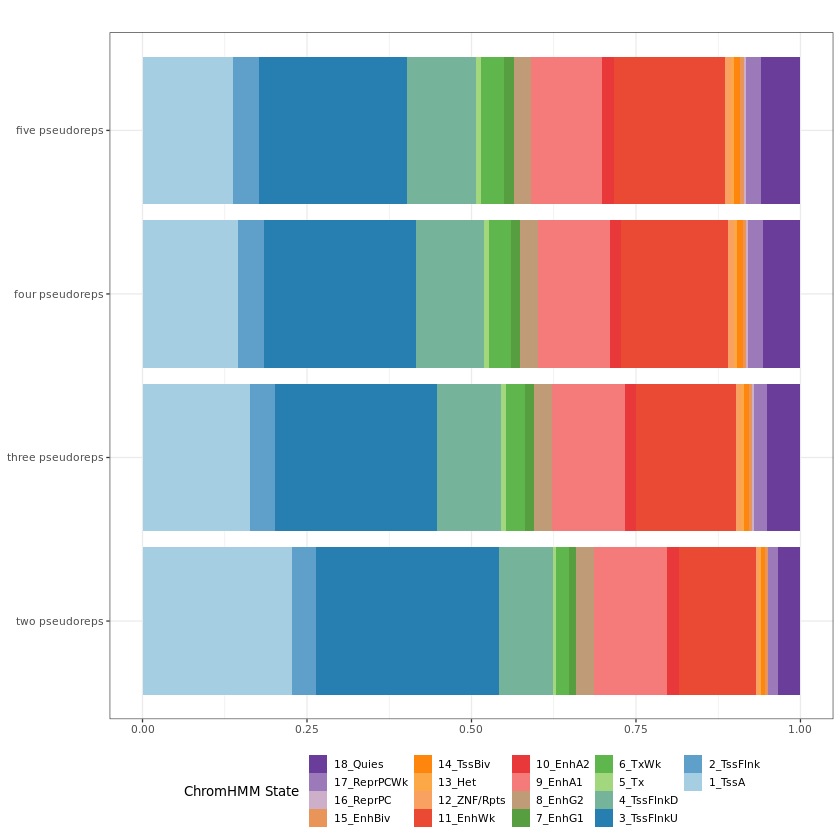

In [47]:
library(tidyverse)
library(ggrepel)
library(RColorBrewer)
library(pals)

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

#Read_tsvs
two <- read_tsv(paste0(dir, "/psuedo_2-reps_ChromHMM.bed"), 
    col_names = c("Chr", "Start", "End", "Chrom_HMM_State")) %>% mutate(Type="two pseudoreps")

three <- read_tsv(paste0(dir, "/psuedo_3-reps_ChromHMM.bed"), 
    col_names = c("Chr", "Start", "End", "Chrom_HMM_State")) %>% mutate(Type="three pseudoreps")

four <- read_tsv(paste0(dir, "/psuedo_4-reps_ChromHMM.bed"), 
    col_names = c("Chr", "Start", "End", "Chrom_HMM_State")) %>% mutate(Type="four pseudoreps")

five <- read_tsv(paste0(dir, "/psuedo_5-reps_ChromHMM.bed"), 
    col_names = c("Chr", "Start", "End", "Chrom_HMM_State")) %>% mutate(Type="five pseudoreps")

#wrangle tsvs
tsv <- bind_rows(two,three,four,five)
tsv$Type <- factor(tsv$Type, levels = c("two pseudoreps", "three pseudoreps", "four pseudoreps", "five pseudoreps"))
tsv_tally <- group_by(tsv, Chrom_HMM_State, Type) %>% tally()
tsv_tally$Chrom_HMM_State <- factor(tsv_tally$Chrom_HMM_State, 
                                    levels = c("1_TssA", "2_TssFlnk", "3_TssFlnkU", "4_TssFlnkD", 
                                               "5_Tx", "6_TxWk", "7_EnhG1", "8_EnhG2", "9_EnhA1", 
                                               "10_EnhA2", "11_EnhWk", "12_ZNF/Rpts", "13_Het", 
                                               "14_TssBiv", "15_EnhBiv", "16_ReprPC", "17_ReprPCWk", 
                                               "18_Quies")) %>% fct_rev()

#define color palette
nb.cols <- 18
mycolors <- colorRampPalette(rev(brewer.pal(10, "Paired")))(nb.cols) 

bar <- ggplot(tsv_tally, aes(y = Type, x = n, fill = Chrom_HMM_State)) + 
  geom_bar(width = 0.9, stat = "identity", size = 0, position = "fill") +
  scale_fill_manual(values = mycolors) +
  ggtitle("") +
  labs(fill="ChromHMM State") +
  theme_bw(base_family = "Arial", base_size = 8) +
  theme(legend.position = "bottom", legend.key.size = unit(0.15, "inches"), plot.title = element_text(hjust = 0.5, face = "bold", size = 12), axis.title = element_blank()) 

bar

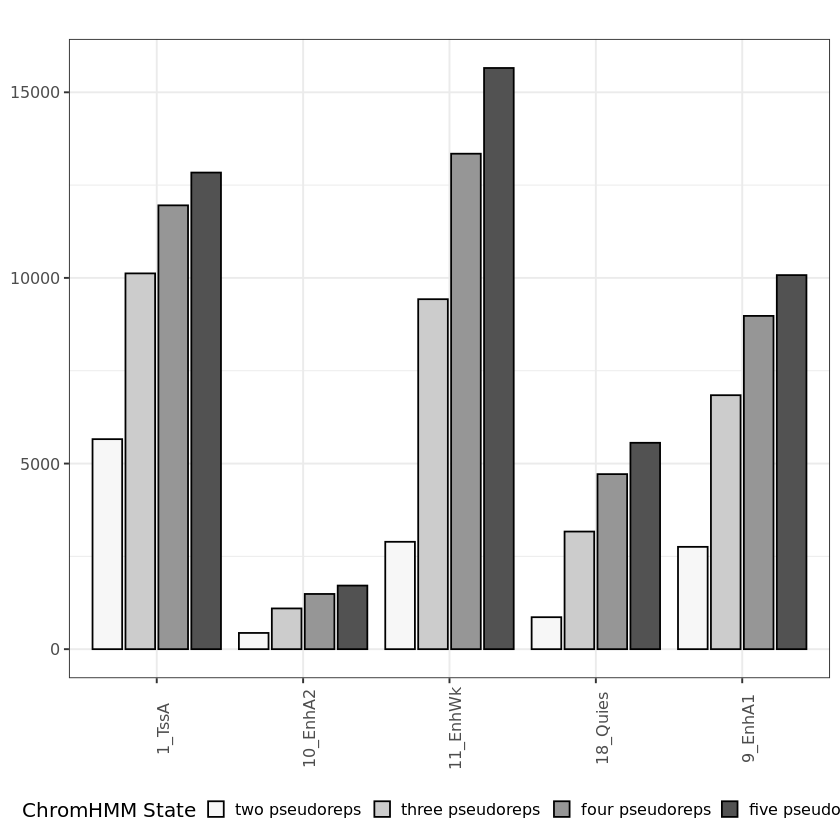

In [38]:
#wrangle tsvs
tsv <- bind_rows(two,three,four,five)
tsv$Type <- factor(tsv$Type, levels = c("two pseudoreps", "three pseudoreps", "four pseudoreps", "five pseudoreps"))
tsv_tally <- group_by(tsv, Chrom_HMM_State, Type) %>% tally()

tsv_tally_filt <- filter(tsv_tally, Chrom_HMM_State == "1_TssA" | Chrom_HMM_State == "9_EnhA1" | Chrom_HMM_State == "10_EnhA2" | 
                             Chrom_HMM_State == "11_EnhWk" | Chrom_HMM_State == "18_Quies")

#define color palette
bar <- ggplot(tsv_tally_filt, aes(fill = Type, y = n, x = Chrom_HMM_State)) + 
  geom_bar(stat = "identity", position = "dodge2", color = "black") +
  scale_fill_brewer(palette = "Greys") +
  ggtitle("") +
  labs(fill="ChromHMM State") +
  theme_bw(base_family = "Arial", base_size = 12) +
  theme(legend.position = "bottom", legend.key.size = unit(0.15, "inches"), plot.title = element_text(hjust = 0.5, face = "bold", size = 12), 
        axis.title = element_blank(), axis.text.x = element_text(angle = 90)) 

bar

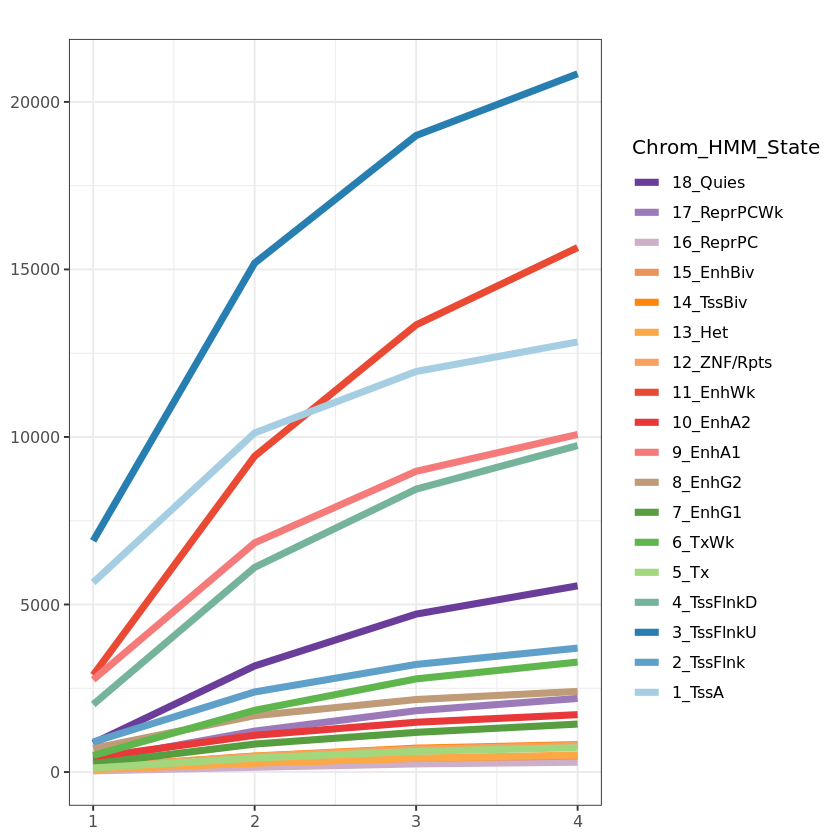

In [62]:
#define color palette
nb.cols <- 18
mycolors <- colorRampPalette(rev(brewer.pal(10, "Paired")))(nb.cols) 

bar <- ggplot(tsv_tally, aes(x = as.numeric(Type), y = n, color = Chrom_HMM_State)) + 
  geom_line(lwd = 2) +
  scale_color_manual(values = mycolors) +
  ggtitle("") +
  labs(fill="ChromHMM State") +
  theme_bw(base_family = "Arial", base_size = 12) +
  theme(legend.position = "right", legend.key.size = unit(0.25, "inches"), plot.title = element_text(hjust = 0.5, face = "bold", size = 12), axis.title = element_blank()) 

bar

In [1]:
%%bash
#look at hiDRA

#BedFiles
CHMM_DIR='/data/hodges_lab/public_data/GM12878/obtained_as_processed_files'
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'
AS="/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink"
res='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

#hiDRA 5reps
bedtools intersect -u -a ${CHMM_DIR}/GM12878_ChromHMM_18-state_E116_18_core_K27ac_hg38lift_mnemonics.bed \
    -b ${dir}/results/hiDRA_active_0.1.merged-bins.bed > ${res}/hidra_5-reps_ChromHMM.bed
    
#hiDRA 3reps
bedtools intersect -u -a ${CHMM_DIR}/GM12878_ChromHMM_18-state_E116_18_core_K27ac_hg38lift_mnemonics.bed \
    -b ${dir}/results/hiDRA_active_3-reps0.1.merged-bins.bed > ${res}/hidra_3-reps_ChromHMM.bed

In [ ]:
library(tidyverse)
library(ggrepel)
library(RColorBrewer)
library(pals)

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

#Read_tsvs
H3 <- read_tsv(paste0(dir, "/hidra_3-reps_ChromHMM.bed"), 
    col_names = c("Chr", "Start", "End", "Chrom_HMM_State")) %>% mutate(Type="HiDRA 3 reps")

H5 <- read_tsv(paste0(dir, "/hidra_5-reps_ChromHMM.bed"), 
    col_names = c("Chr", "Start", "End", "Chrom_HMM_State")) %>% mutate(Type="HiDRA 5 reps")

AS <- read_tsv(paste0("/data/hodges_lab/ATAC-STARR_B-cells/results/AS-regions_chromHMM-assignment/GM12878inGM12878_active_0.1padj_50-bin_ChromHMM.bed"), 
    col_names = c("Chr", "Start", "End", "Chrom_HMM_State")) %>% mutate(Type="ATAC-STARR-seq")

#wrangle tsvs
tsv <- bind_rows(H3,H5,AS)
tsv$Type <- factor(tsv$Type, levels = c("ATAC-STARR-seq", "HiDRA 3 reps", "HiDRA 5 reps"))
tsv_tally <- group_by(tsv, Chrom_HMM_State, Type) %>% tally()
tsv_tally$Chrom_HMM_State <- factor(tsv_tally$Chrom_HMM_State, 
                                    levels = c("1_TssA", "2_TssFlnk", "3_TssFlnkU", "4_TssFlnkD", 
                                               "5_Tx", "6_TxWk", "7_EnhG1", "8_EnhG2", "9_EnhA1", 
                                               "10_EnhA2", "11_EnhWk", "12_ZNF/Rpts", "13_Het", 
                                               "14_TssBiv", "15_EnhBiv", "16_ReprPC", "17_ReprPCWk", 
                                               "18_Quies")) %>% fct_rev()

nb.cols <- 18
mycolors <- colorRampPalette(rev(brewer.pal(10, "Paired")))(nb.cols) 

bar <- ggplot(tsv_tally, aes(y = Type, x = n, fill = Chrom_HMM_State)) + 
  geom_bar(stat="identity", position = "fill") +
  scale_fill_manual(values = mycolors) +
  ggtitle("") +
  labs(fill="ChromHMM State") +
  theme_bw(base_family = "Arial", base_size = 12) +
  theme(legend.position = "bottom", legend.key.size = unit(0.25, "inches"), plot.title = element_text(hjust = 0.5, face = "bold", size = 12), axis.title = element_blank()) 

bar


── Column specification ────────────────────────────────────────────────────────
cols(
  Chr = col_character(),
  Start = col_double(),
  End = col_double(),
  Chrom_HMM_State = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  Chr = col_character(),
  Start = col_double(),
  End = col_double(),
  Chrom_HMM_State = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  Chr = col_character(),
  Start = col_double(),
  End = col_double(),
  Chrom_HMM_State = col_character()
)




## Summary of replicate number analyses

It looks like replicate number strongly influences number of regions called. With two replicates we get 26,966 regions. This jumps up to 74,410 with three replicates, and all the way to 117,674 with five replicates. Given the biggest jump is from 2 to 3, I think adding only one additional replicate would be adequate for our case. 

Additionally, we see that almost all of our original ~30,000 regions are contained within the 3 psudeo replicate calls (28,461 of ~30,000). This means that adding a third replicate would add regions to our current set rather than lose some and gain others.  

Altogether I conclude that we should generate and sequence another replicate. While not ideal, we need to practice good scientific rigor and reproducibility.

UPDATE: I did this and updated numbers above. 

# Why so many silencers?

We got the following comment in our reviews: "Seeing more silencing than activating elements, while repressing elements seem to contribute less in previous STARR-seq and other MPRA studies." 

The answer to this question is unclear but could be hinted by the fact that silencers are promoter enriched. Why do silencing promoters yield fewer RNA reads than basal. The answer could be technical or biological. Our analysis hints at biological based on different TF motif enrichment, TF footprinting, and histone modifications. 

How do we further prove this is biological? Rule out technical? 

Or can we just use current articles as a way to provide the logic that more repressors exist than activators?

I don't really know where to start. 

We could argue these promoters are at bivalent modification sites where genes initiate quick activation in reponse to stimuli. We could show enrichment of stimulatory genes pathways. 

End of the day, we can use other papers to explain this one. I do not think we need additional analyses. 